# Downloading and Generating Pickle for Numerical Data

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import os

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

import io
from lxml import etree
from dateutil.relativedelta import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')


## Load FOMC Meeting
### Chairpersons

In [ ]:
# FOMC Chairperson's list for Making a dataframe
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

Surname FirstName   FromDate     ToDate
0    Volcker      Paul 1979-08-06 1987-08-10
1  Greenspan      Alan 1987-08-11 2006-01-31
2   Bernanke       Ben 2006-02-01 2014-01-31
3     Yellen     Janet 2014-02-03 2018-02-03
4     Powell    Jerome 2018-02-05 2022-02-05

In [ ]:
def get_chair(x): 
  
    #Return a tuple of chairperson's Fullname for the given date x.
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

### Loading Calendar from Pickle

In [ ]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

calendar = pickle.load(file)
file.close()
print(calendar.shape)
calendar

(454, 4)


date  unscheduled  forecast  confcall
0   1980-01-09        False     False     False
1   1980-02-05        False     False     False
2   1980-02-22        False     False      True
3   1980-03-07        False     False      True
4   1980-03-18        False     False     False
..         ...          ...       ...       ...
449 2021-06-16        False      True     False
450 2021-07-28        False     False     False
451 2021-09-22        False      True     False
452 2021-11-03        False     False     False
453 2021-12-15        False      True     False

[454 rows x 4 columns]

In [ ]:
calendar = calendar.loc[calendar['date'] >= dt.datetime(1982, 9, 27)]

# Setting date as index for the dataframe to refer to the table
calendar.set_index('date', inplace=True)
calendar.head()

unscheduled  forecast  confcall
date                                       
1982-10-05        False     False     False
1982-11-16        False     False     False
1982-12-21        False     False     False
1983-01-14        False     False      True
1983-01-21        False     False      True

### Add Chairperson to Calendar

In [ ]:
#Merging the Chairperson details with the FOMC_minutes
calendar['ChairPerson'] = calendar.index.map(get_chair)
calendar

unscheduled  forecast  confcall    ChairPerson
date                                                      
1982-10-05        False     False     False   Paul Volcker
1982-11-16        False     False     False   Paul Volcker
1982-12-21        False     False     False   Paul Volcker
1983-01-14        False     False      True   Paul Volcker
1983-01-21        False     False      True   Paul Volcker
...                 ...       ...       ...            ...
2021-06-16        False      True     False  Jerome Powell
2021-07-28        False     False     False  Jerome Powell
2021-09-22        False      True     False  Jerome Powell
2021-11-03        False     False     False  Jerome Powell
2021-12-15        False      True     False  Jerome Powell

[411 rows x 4 columns]

### Target FED Rate
#### Downloading From Quandl
Quandl provide APIs and library for each data access to multiple sources.
Created a python function to download data, so please execute it first. api_key can be found on your Quandl Account.

` python QuandlGetData api_key 1980-01-01 `

Also, it can be accessed via Web API.
```
import quandl
import getpass

# Enter Quandle API Key
quandl.ApiConfig.api_key = getpass.getpass('Enter your API Key for Quandl')

data = quandl.get("FRED/DFEDTAR", start_date="1980-01-01")
```

For the scope of this project the data is already downloaded and saved in the corresponding location of folder.

In [ ]:
# After some careful analysis we had to download the FED rate data file from the different csv documents


till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(from08l, names=['Date', 'Rate'], header=0)


fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

Rate  diff
Date                   
1982-09-27  10.25   NaN
1982-09-28  10.25  0.00
1982-09-29  10.25  0.00
1982-09-30  10.25  0.00
1982-10-01  10.00 -0.25
...           ...   ...
2020-11-08   0.00  0.00
2020-11-09   0.00  0.00
2020-11-10   0.00  0.00
2020-11-11   0.00  0.00
2020-11-12   0.00  0.00

[13927 rows x 2 columns]

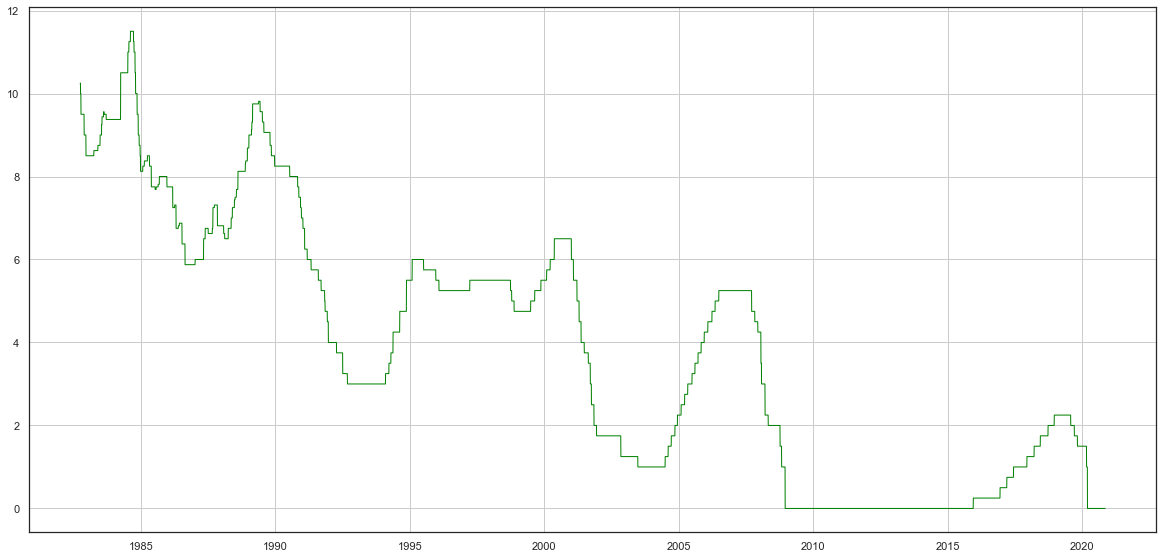

In [ ]:
#plotting the Fed Rates

figure, axis = plt.subplots()

axis.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)

axis.grid(True)
plt.show()

### Effective FED Rate

In [ ]:
# Downloaded FED rate again from Quandl with Difference

filename = '../data/MarketData/Quandl/FRED_DFF.csv'

dff = pd.read_csv(filename, names=['DATE', 'DFF'], header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

DFF  diff
DATE                   
1980-01-01  14.77   NaN
1980-01-02  14.00 -0.77
1980-01-03  13.89 -0.11
1980-01-04  14.00  0.11
1980-01-05  14.00  0.00
...           ...   ...
2020-11-08   0.09  0.00
2020-11-09   0.09  0.00
2020-11-10   0.09  0.00
2020-11-11   0.09  0.00
2020-11-12   0.09  0.00

[14927 rows x 2 columns]

(498, 2)


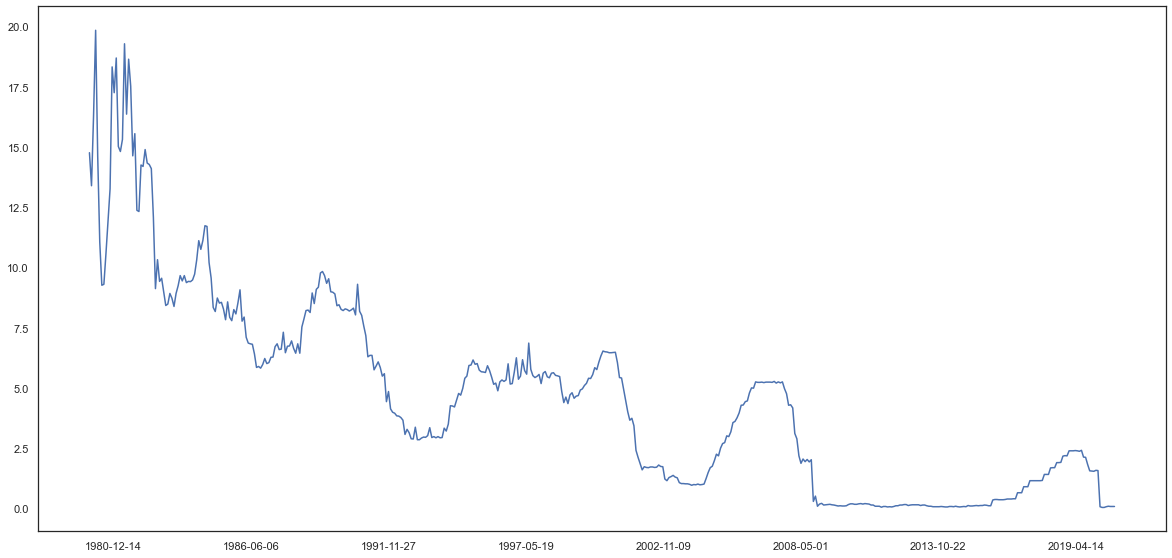

In [ ]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

## Load Economic Indices

### GDP

Real GDP, Quarterly announced used a source of Meta Data

In [ ]:
filename = '../data/MarketData/Quandl/FRED_GDPC1.csv'

#load the data
gdpc1 = pd.read_csv(filename, names=['DATE', 'GDPC1'], header=0)
#set the index to data
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE']
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100
gdpc1

GDPC1  diff_prev  diff_year
DATE                                       
1980-01-01   6837.641        NaN        NaN
1980-04-01   6696.753  -2.060477        NaN
1980-07-01   6688.794  -0.118849        NaN
1980-10-01   6813.535   1.864925        NaN
1981-01-01   6947.042   1.959438   1.599982
...               ...        ...        ...
2019-07-01  19141.744   0.636915   2.076481
2019-10-01  19253.959   0.586232   2.338885
2020-01-01  19010.848  -1.262655   0.319261
2020-04-01  17302.511  -8.986117  -9.032775
2020-07-01  18583.984   7.406283  -2.913841

[163 rows x 3 columns]

### Potential GDP

In [ ]:
filename = '../data/MarketData/Quandl/FRED_GDPPOT.csv'


#load the data
gdppot = pd.read_csv(filename, names=['DATE', 'GDPPOT'], header=0)
#reset the index to date
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

GDPPOT  diff_prev  diff_year
DATE                                          
1980-01-01   6839.712129        NaN        NaN
1980-04-01   6874.805763   0.513086        NaN
1980-07-01   6903.225210   0.413385        NaN
1980-10-01   6934.664398   0.455428        NaN
1981-01-01   6971.899150   0.536937   1.932640
...                  ...        ...        ...
2029-10-01  22645.810000   0.447462   1.814980
2030-01-01  22746.660000   0.445336   1.807562
2030-04-01  22847.250000   0.442219   1.796875
2030-07-01  22947.420000   0.438434   1.785279
2030-10-01  23047.200000   0.434820   1.772469

[204 rows x 3 columns]

### Personal Consumption: PCE

Use Core PCE excluding Food and Energy as FRB takes this index as important indicator. <BR />
It is announced monthly around the last working days of each month for the previous month.

In [ ]:
filename = '../data/MarketData/Quandl/FRED_PCEPILFE.csv'

#load the datafile
pcepilfe = pd.read_csv(filename, names=['DATE', 'PCEPILFE'], header=0)

#reset the index to date
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])


# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

PCEPILFE  diff_prev  diff_year
DATE                                      
1980-01-01    39.187        NaN        NaN
1980-02-01    39.578   0.997780        NaN
1980-03-01    39.945   0.927283        NaN
1980-04-01    40.150   0.513206        NaN
1980-05-01    40.473   0.804483        NaN
...              ...        ...        ...
2020-05-01   112.755   0.203509   1.005984
2020-06-01   113.145   0.345883   1.136100
2020-07-01   113.462   0.280171   1.253826
2020-08-01   113.838   0.331388   1.445427
2020-09-01   114.041   0.178324   1.548503

[489 rows x 3 columns]

### Personal Consumption: CPI

CPI's coverage is less than PCE but announced monthly around 10th of each month for the previous month, which is earlier than PCE. <BR />
As this is available to some meetings even before PCE announcement, take this index as well.

In [ ]:
filename = '../data/MarketData/Quandl/FRED_CPIAUCSL.csv'

#load the CPI data
cpiaucsl = pd.read_csv(filename, names=['DATE', 'CPIAUCSL'], header=0)
#Reset the dataframe to make the date as the index again
cpiaucsl = cpiaucsl.set_index(pd.to_datetime(cpiaucsl['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl

CPIAUCSL  diff_prev  diff_year
DATE                                      
1980-01-01    78.000        NaN        NaN
1980-02-01    79.000   1.282051        NaN
1980-03-01    80.100   1.392405        NaN
1980-04-01    80.900   0.998752        NaN
1980-05-01    81.700   0.988875        NaN
...              ...        ...        ...
2020-06-01   257.214   0.565356   0.709470
2020-07-01   258.723   0.586671   1.029338
2020-08-01   259.681   0.370280   1.321529
2020-09-01   260.209   0.203326   1.409236
2020-10-01   260.325   0.044580   1.203597

[490 rows x 3 columns]

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time. <BR />
As bigger number indicates negative, turn the sign to have negative number.

In [ ]:
filename = '../data/MarketData/Quandl/FRED_UNRATE.csv'

#load the dataframe to read the CSV
unrate = pd.read_csv(filename, names=['DATE', 'UNRATE'], header=0)
#Reset the index to date
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

#Negation of the UnEmployment Rate for better Factoring
unrate['UNRATE'] = unrate['UNRATE'] * -1

# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

UNRATE  diff_prev  diff_year
DATE                                    
1980-01-01    -6.3        NaN        NaN
1980-02-01    -6.3        0.0        NaN
1980-03-01    -6.3        0.0        NaN
1980-04-01    -6.9       -0.6        NaN
1980-05-01    -7.5       -0.6        NaN
...            ...        ...        ...
2020-06-01   -11.1        2.2       -7.4
2020-07-01   -10.2        0.9       -6.5
2020-08-01    -8.4        1.8       -4.7
2020-09-01    -7.9        0.5       -4.4
2020-10-01    -6.9        1.0       -3.3

[490 rows x 3 columns]

###  Employment

In [ ]:

filename = '../data/MarketData/Quandl/FRED_PAYEMS.csv'

#Read the CSV
emp = pd.read_csv(filename, names=['DATE', 'PAYEMS'], header=0)
#Reset the Dataframe
emp = emp.set_index(pd.to_datetime(emp['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

# Find the difference from previous value and make it resasonable
emp['diff_prev'] = emp['PAYEMS'].diff()
emp['diff_year'] = emp['PAYEMS'].diff(periods=12)
emp

PAYEMS  diff_prev  diff_year
DATE                                      
1980-01-01   90800.0        NaN        NaN
1980-02-01   90883.0       83.0        NaN
1980-03-01   90994.0      111.0        NaN
1980-04-01   90849.0     -145.0        NaN
1980-05-01   90420.0     -429.0        NaN
...              ...        ...        ...
2020-06-01  137809.0     4781.0   -12950.0
2020-07-01  139570.0     1761.0   -11383.0
2020-08-01  141063.0     1493.0   -10097.0
2020-09-01  141735.0      672.0    -9633.0
2020-10-01  142373.0      638.0    -9180.0

[490 rows x 3 columns]

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [ ]:
# Load ISM PMI
filename = '../data/MarketData/Quandl/ISM_MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, names=['Date', 'PMI'], header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

PMI  diff_prev  diff_year
Date                                  
1980-01-01  46.2        NaN        NaN
1980-02-01  50.2        4.0        NaN
1980-03-01  43.6       -6.6        NaN
1980-04-01  37.4       -6.2        NaN
1980-05-01  29.4       -8.0        NaN
...          ...        ...        ...
2020-06-01  52.6        9.5        1.0
2020-07-01  54.2        1.6        2.9
2020-08-01  56.0        1.8        7.2
2020-09-01  55.4       -0.6        7.2
2020-10-01  59.3        3.9       10.8

[490 rows x 3 columns]

In [ ]:
# Load ISM NMI
filename = '../data/MarketData/Quandl/ISM_NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, names=['Date', 'NMI'], header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

NMI  diff_prev  diff_year
Date                                  
2008-01-01  45.0        NaN        NaN
2008-02-01  49.9        4.9        NaN
2008-03-01  49.4       -0.5        NaN
2008-04-01  51.8        2.4        NaN
2008-05-01  51.4       -0.4        NaN
...          ...        ...        ...
2020-06-01  57.1       11.7        2.0
2020-07-01  58.1        1.0        3.3
2020-08-01  56.9       -1.2        0.9
2020-09-01  57.8        0.9        4.3
2020-10-01  56.6       -1.2        2.2

[154 rows x 3 columns]

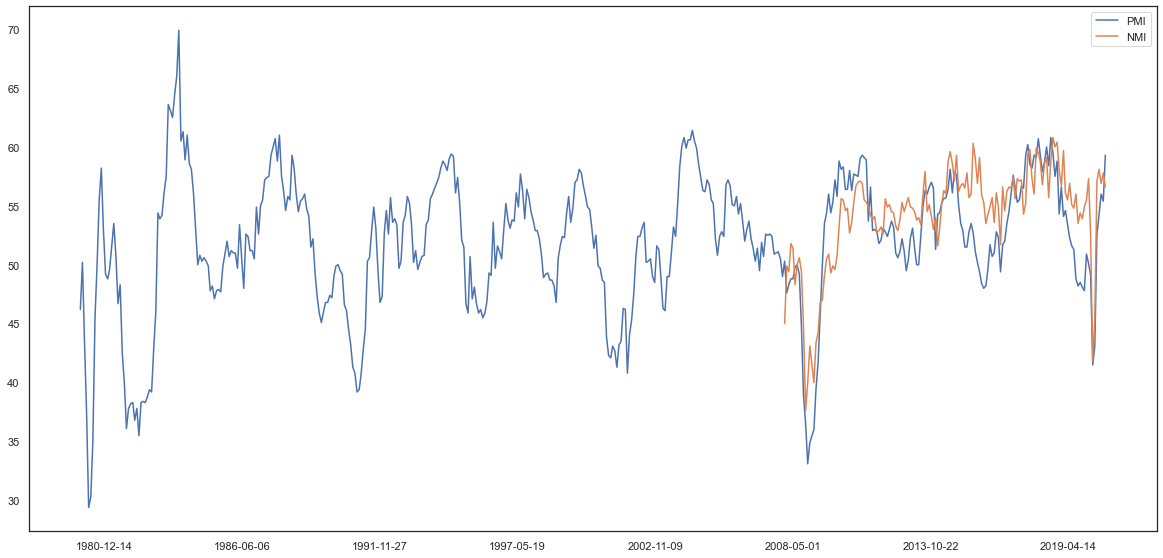

In [ ]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()

### Retail Sales
Retail sales is an important indicator of the current economic situation.
It is usually announced around the middle of each month (15th) for the previous month.

In [ ]:
# Load Advance Real Retail and Food Services Sales

filename = '../data/MarketData/Quandl/FRED_RRSFS.csv'

#load the csv data
rrsfs = pd.read_csv(filename, names=['DATE', 'RRSFS'], header=0)
#load the reset date
rrsfs = rrsfs.set_index(pd.to_datetime(rrsfs['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs



RRSFS  diff_prev  diff_year
DATE                                      
1992-01-01  118651.0        NaN        NaN
1992-02-01  118480.0  -0.144120        NaN
1992-03-01  117700.0  -0.658339        NaN
1992-04-01  118156.0   0.387426        NaN
1992-05-01  118548.0   0.331765        NaN
...              ...        ...        ...
2020-05-01  190883.0  18.341827  -5.773085
2020-06-01  206039.0   7.939942   1.510546
2020-07-01  207142.0   0.535336   1.654308
2020-08-01  207554.0   0.198897   1.424460
2020-09-01  211083.0   1.700280   3.891700

[345 rows x 3 columns]

### New Home Sales
New home sales is another important index to know the retail sales figure. <br />
It is usually announced around a week before the end of each month for the previous month.

In [ ]:
filename = '../data/MarketData/Quandl/FRED_HSN1F.csv'

#load the data
hsn1f = pd.read_csv(filename, names=['DATE', 'HSN1F'], header=0)
#Reseting the Dataframe to the data
hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

HSN1F  diff_prev  diff_year
DATE                                   
1980-01-01  592.0        NaN        NaN
1980-02-01  541.0  -8.614865        NaN
1980-03-01  474.0 -12.384473        NaN
1980-04-01  370.0 -21.940928        NaN
1980-05-01  469.0  26.756757        NaN
...           ...        ...        ...
2020-05-01  698.0  22.456140  16.333333
2020-06-01  840.0  20.343840  15.702479
2020-07-01  965.0  14.880952  45.990923
2020-08-01  994.0   3.005181  40.793201
2020-09-01  959.0  -3.521127  32.093664

[489 rows x 3 columns]

### Treasury Rates

In [ ]:
filename = '../data/MarketData/Quandl/USTREASURY_YIELD.csv'


treasury_q = pd.read_csv(filename, header=0)

treasury_q = treasury_q.set_index(pd.to_datetime(treasury_q['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
treasury_q


1 MO  2 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  \
Date                                                                      
1990-01-02   NaN   NaN  7.83  7.89  7.81  7.87  7.90  7.87  7.98   7.94   
1990-01-03   NaN   NaN  7.89  7.94  7.85  7.94  7.96  7.92  8.04   7.99   
1990-01-04   NaN   NaN  7.84  7.90  7.82  7.92  7.93  7.91  8.02   7.98   
1990-01-05   NaN   NaN  7.79  7.85  7.79  7.90  7.94  7.92  8.03   7.99   
1990-01-08   NaN   NaN  7.79  7.88  7.81  7.90  7.95  7.92  8.05   8.02   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
2020-11-06  0.10  0.10  0.10  0.11  0.12  0.16  0.21  0.36  0.59   0.83   
2020-11-09  0.10  0.10  0.11  0.11  0.12  0.17  0.25  0.44  0.70   0.96   
2020-11-10  0.09  0.09  0.10  0.11  0.12  0.19  0.26  0.46  0.72   0.98   
2020-11-12  0.10  0.11  0.10  0.10  0.13  0.17  0.23  0.40  0.64   0.88   
2020-11-13  0.10  0.09  0.09  0.10  0.12  0.17  0.23  0.41  0.65   0.89   

            20 YR  30 YR  
Date                      
1990-01-02    NaN   8.00  
1990-01-03    NaN   8.04  
1990-01-04    NaN   8.04  
1990-01-05    NaN   8.06  
1990-01-08    NaN   8.09  
...           ...    ...  
2020-11-06   1.37   1.60  
2020-11-09   1.51   1.73  
2020-11-10   1.53   1.75  
2020-11-12   1.42   1.64  
2020-11-13   1.43   1.65  

[7724 rows x 12 columns]

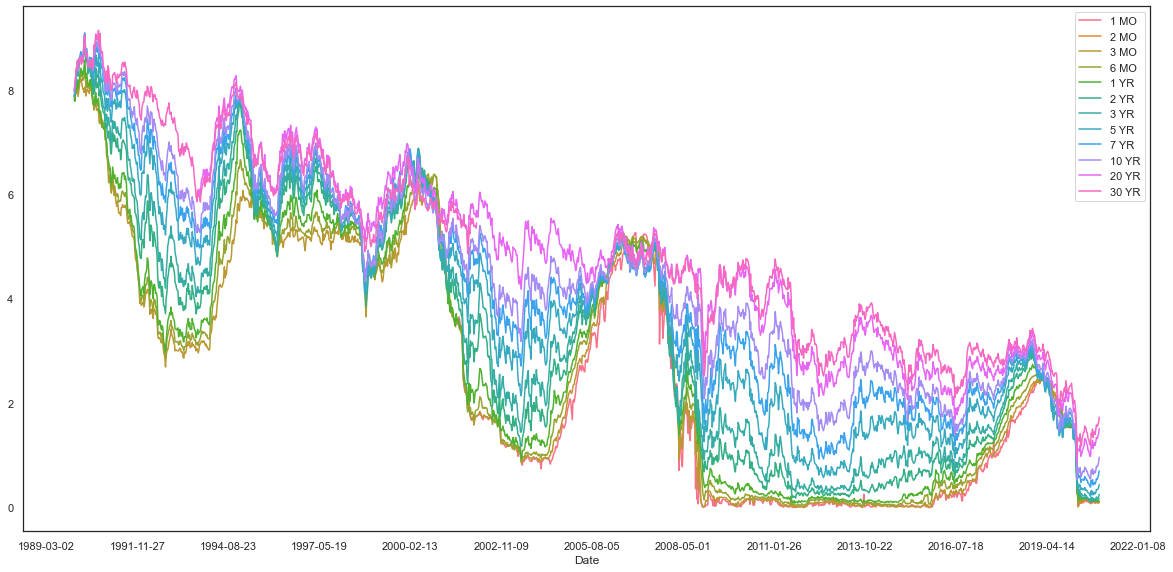

In [ ]:
# Use every 5th row as it has too many data points
treasury_q_5 = treasury_q.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_q_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

## Adding some extra details to the dataframe

### Adding Rate Decisions to the Dataframe

In [ ]:


# Use the target rate three days after the meeting as target announced, compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

from ipywidgets import IntProgress

r_list = []
d_list = []
r_diff_list = []

for i in tqdm(range(len(calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            r_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            r_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                d_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                d_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                d_list.append(-1)
            break
    if not_found:
        r_list.append(np.nan)
        d_list.append(np.nan)
        r_diff_list.append(np.nan)

calendar.loc[:,'Rate'] = r_list
calendar.loc[:,'RateDiff'] = r_diff_list
calendar.loc[:,'RateDecision'] = d_list
calendar['RateDecision'] = calendar['RateDecision'].astype('Int8')

calendar

unscheduled  forecast  confcall    ChairPerson  Rate  RateDiff  \
date                                                                         
1982-10-05        False     False     False   Paul Volcker   9.5      -0.5   
1982-11-16        False     False     False   Paul Volcker   9.0      -0.5   
1982-12-21        False     False     False   Paul Volcker   8.5       0.0   
1983-01-14        False     False      True   Paul Volcker   8.5       0.0   
1983-01-21        False     False      True   Paul Volcker   8.5       0.0   
...                 ...       ...       ...            ...   ...       ...   
2021-06-16        False      True     False  Jerome Powell   NaN       NaN   
2021-07-28        False     False     False  Jerome Powell   NaN       NaN   
2021-09-22        False      True     False  Jerome Powell   NaN       NaN   
2021-11-03        False     False     False  Jerome Powell   NaN       NaN   
2021-12-15        False      True     False  Jerome Powell   NaN       NaN   

            RateDecision  
date                      
1982-10-05            -1  
1982-11-16            -1  
1982-12-21             0  
1983-01-14             0  
1983-01-21             0  
...                  ...  
2021-06-16          <NA>  
2021-07-28          <NA>  
2021-09-22          <NA>  
2021-11-03          <NA>  
2021-12-15          <NA>  

[411 rows x 7 columns]

In [ ]:
calendar.loc[calendar['Rate'].isnull()]

unscheduled  forecast  confcall    ChairPerson  Rate  RateDiff  \
date                                                                         
2020-12-16        False      True     False  Jerome Powell   NaN       NaN   
2021-01-27        False     False     False  Jerome Powell   NaN       NaN   
2021-03-17        False      True     False  Jerome Powell   NaN       NaN   
2021-04-28        False     False     False  Jerome Powell   NaN       NaN   
2021-06-16        False      True     False  Jerome Powell   NaN       NaN   
2021-07-28        False     False     False  Jerome Powell   NaN       NaN   
2021-09-22        False      True     False  Jerome Powell   NaN       NaN   
2021-11-03        False     False     False  Jerome Powell   NaN       NaN   
2021-12-15        False      True     False  Jerome Powell   NaN       NaN   

            RateDecision  
date                      
2020-12-16          <NA>  
2021-01-27          <NA>  
2021-03-17          <NA>  
2021-04-28          <NA>  
2021-06-16          <NA>  
2021-07-28          <NA>  
2021-09-22          <NA>  
2021-11-03          <NA>  
2021-12-15          <NA>

In [ ]:
# Remove the future date
calendar = calendar.loc[calendar.index < dt.datetime.now()]

# Confirm no null rate remains
calendar.loc[calendar['Rate'].isnull()]

Empty DataFrame
Columns: [unscheduled, forecast, confcall, ChairPerson, Rate, RateDiff, RateDecision]
Index: []

### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.
Took inspiration from an online Github Gist for these facts

In [ ]:
# Add 2008-11-25 to calendar when QE was first announced but not in FOMC Calendar
# Mark RateDecision = -1 (lower) even when rate is not changed but additional quantitative measures were announced

# QE1 Announced
rec_20081125 = pd.Series([True, False, False, 'Ben Bernanke', 0, -1, -1], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))

if calendar.loc[calendar.index == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    calendar = calendar.append(rec_20081125)

# Make the other timings of QE Expansion lowering events (consider the effect as -0.5%)
calendar.loc[calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE1 Expanded
calendar.loc[calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE2 Announced
calendar.loc[calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Announced
calendar.loc[calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Extended
calendar.loc[calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Announced
calendar.loc[calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Expanded

# It was announced QE ends - regard this as hike
calendar.loc[calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Announced
calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Begins
calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5) # QE3 Terminated
calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization
calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5) # Stated Balance Sheet Normalization Begins in Oct
calendar.sort_index(ascending=True, inplace=True)
calendar



unscheduled  forecast  confcall    ChairPerson  Rate  RateDiff  \
date                                                                         
1982-10-05        False     False     False   Paul Volcker   9.5      -0.5   
1982-11-16        False     False     False   Paul Volcker   9.0      -0.5   
1982-12-21        False     False     False   Paul Volcker   8.5       0.0   
1983-01-14        False     False      True   Paul Volcker   8.5       0.0   
1983-01-21        False     False      True   Paul Volcker   8.5       0.0   
...                 ...       ...       ...            ...   ...       ...   
2020-06-10        False      True     False  Jerome Powell   0.0       0.0   
2020-07-29        False     False     False  Jerome Powell   0.0       0.0   
2020-08-27        False     False     False  Jerome Powell   0.0       0.0   
2020-09-16        False      True     False  Jerome Powell   0.0       0.0   
2020-11-05        False     False     False  Jerome Powell   0.0       0.0   

            RateDecision  
date                      
1982-10-05            -1  
1982-11-16            -1  
1982-12-21             0  
1983-01-14             0  
1983-01-21             0  
...                  ...  
2020-06-10             0  
2020-07-29             0  
2020-08-27             0  
2020-09-16             0  
2020-11-05             0  

[403 rows x 7 columns]

### Add major economic indices

In [ ]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):

    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [ ]:
def add_market_data(calendar_df, window=1):
    '''
    Search the latest available market data using get_available_latest and retun a new dataframe with the market data.
    Moving average is applied to market data for the give window size.
    '''
    # First copy the caleander dataframe and drop Rate is NaN because this is the answer
    df = calendar_df.copy(deep=True)
    df.dropna(subset=['Rate'], inplace=True)
    
    # GDP is announced quarterly, the end of following month (preliminary)
    print("Processing GDP...")
    df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
    = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    print("Processing Potential GDP...")
    df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
    = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # PCE is announced monthly, at the end of following month
    print("Processing PCE...")
    df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
    = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))

    # CPI is announced monthly, around 10th of the following month
    print("Processing CPI...")
    df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
    = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Unemployemnt...")
    df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
    = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Employment...")
    df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
    = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM PMI is areannounced monthly, around 1st of the following month
    print("Processing ISM PMI...")
    df['PMI_date'], df['PMI_value'], df['PMI_diff_prev'], df['PMI_diff_year'] \
    = get_available_latest(df, ism_pmi.rolling(window).mean(), 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM NMI is areannounced monthly, around 1st of the following month
    print("Processing ISM NMI...")
    df['NMI_date'], df['NMI_value'], df['NMI_diff_prev'], df['NMI_diff_year'] \
    = get_available_latest(df, ism_nmi.rolling(window).mean(), 'NMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Retail Sales is announced monthly, around 15th of the following month
    print("Processing Retail Sales...")
    df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
    = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # New Home Sales is announced monthly, around a week before the end of the following month
    print("Processing New Home Sales...")
    df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
    = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
    
    return df

In [ ]:
nontext_data = add_market_data(fomc_calendar)

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...


In [ ]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...



Processing ISM NMI...



Processing Retail Sales...



Processing New Home Sales...


### Add Taylor Rule
Use the FOMC website to understand how to take the taylor, differential and interia based interest rates. These rates are often taken into consideration by the FOMC members for choosing their decision


In [ ]:
# Create taylor dataframe
taylor = fedrate_df.copy(deep=True)

# Obtain available index used to calculate Taylor rule each day
_, taylor['Y'],_,_ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'],_,_ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100

_, _,_, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']

taylor['r'] = 2



In [ ]:
# Calculate Taylor Rule
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']

# Calculate Balanced-approach Rule
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)

# Calculate Inertia Rule
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']

# Drop unnecessary columns
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

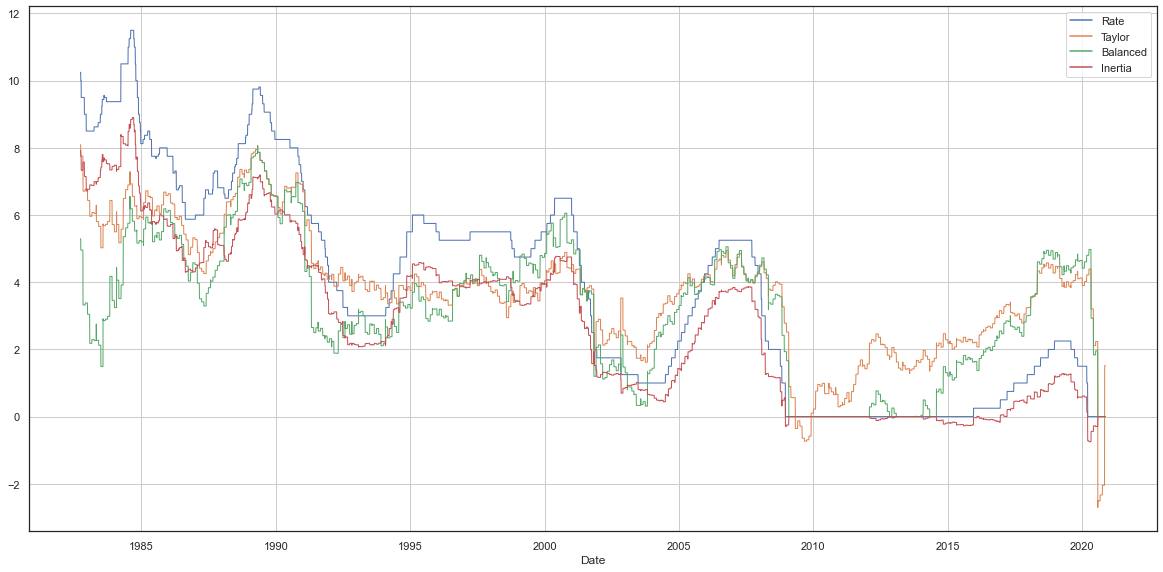

In [ ]:
# Plot
# Use every 5th row as it has too many data points
# taylor_5 = taylor.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.grid(True)
plt.show()

In [ ]:
# Deviation from Rate, which may trigger the rate change
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']

taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)

taylor

Rate    Taylor  Balanced   Inertia  Taylor-Rate  Balanced-Rate  \
Date                                                                          
1982-09-27  10.25  8.091557  5.293115  7.918533    -2.158443      -4.956885   
1982-09-28  10.25  8.091557  5.293115  7.918533    -2.158443      -4.956885   
1982-09-29  10.25  8.091557  5.293115  7.918533    -2.158443      -4.956885   
1982-09-30  10.25  8.091557  5.293115  7.918533    -2.158443      -4.956885   
1982-10-01  10.00  7.755145  4.956703  7.756494    -2.244855      -5.043297   
...           ...       ...       ...       ...          ...            ...   
2020-11-08   0.00  1.516204  0.000000  0.000000     1.516204       0.000000   
2020-11-09   0.00  1.516204  0.000000  0.000000     1.516204       0.000000   
2020-11-10   0.00  1.516204  0.000000  0.000000     1.516204       0.000000   
2020-11-11   0.00  1.516204  0.000000  0.000000     1.516204       0.000000   
2020-11-12   0.00  1.516204  0.000000  0.000000     1.516204       0.000000   

            Inertia-Rate  Taylor_diff  Balanced_diff  Inertia_diff  
Date                                                                
1982-09-27     -2.331467          NaN            NaN           NaN  
1982-09-28     -2.331467     0.000000       0.000000      0.000000  
1982-09-29     -2.331467     0.000000       0.000000      0.000000  
1982-09-30     -2.331467     0.000000       0.000000      0.000000  
1982-10-01     -2.243506    -0.336412      -0.336412     -0.162038  
...                  ...          ...            ...           ...  
2020-11-08      0.000000     0.000000       0.000000      0.000000  
2020-11-09      0.000000     0.000000       0.000000      0.000000  
2020-11-10      0.000000     0.000000       0.000000      0.000000  
2020-11-11      0.000000     0.000000       0.000000      0.000000  
2020-11-12      0.000000     0.000000       0.000000      0.000000  

[13927 rows x 10 columns]

In [ ]:
def add_taylor(df, window=1):

  #Adding the taylor series data to the main dataframe with other meta data values
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)

In [ ]:
add_taylor(nontext_data)
# add_taylor(nontext_ma2, 60)
# add_taylor(nontext_ma3, 90)
# add_taylor(nontext_ma6, 180)
# add_taylor(nontext_ma12, 360)

In [ ]:
calendar.index.get_level_values(0).values

array(['1982-10-05T00:00:00.000000000', '1982-11-16T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1983-01-14T00:00:00.000000000',
       '1983-01-21T00:00:00.000000000', '1983-01-28T00:00:00.000000000',
       '1983-02-09T00:00:00.000000000', '1983-03-29T00:00:00.000000000',
       '1983-04-29T00:00:00.000000000', '1983-05-24T00:00:00.000000000',
       '1983-06-23T00:00:00.000000000', '1983-07-13T00:00:00.000000000',
       '1983-08-23T00:00:00.000000000', '1983-09-08T00:00:00.000000000',
       '1983-10-04T00:00:00.000000000', '1983-11-15T00:00:00.000000000',
       '1983-12-20T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-03-20T00:00:00.000000000', '1984-03-27T00:00:00.000000000',
       '1984-05-22T00:00:00.000000000', '1984-07-17T00:00:00.000000000',
       '1984-08-21T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1984-11-07T00:00:00.000000000', '1984-12-18T00:00:00.000000000',
       '1985-01-18T00:00:00.000000000', '1985-02-13

In [ ]:
calendar.loc['2020-06-10', 'Rate'] = 0
calendar.loc['2020-07-29', 'Rate'] = 0
calendar.loc['2020-06-10', 'RateDiff'] = 0
calendar.loc['2020-07-29', 'RateDiff'] = 0

# Save the Numerical data

In [ ]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save data
save_data(nontext_data, 'nontext_data')
# save_data(nontext_ma2, 'nontext_ma2')
# save_data(nontext_ma3, 'nontext_ma3')
# save_data(nontext_ma6, 'nontext_ma6')
# save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury_q, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')

# EDA and Feature Engineering for Meta Data

In [ ]:
# Python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import re
import pickle

import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter


import warnings
warnings.filterwarnings('ignore')

## Load preprocessed data

In [ ]:
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(403, 57)


unscheduled  forecast  confcall   ChairPerson  Rate  RateDiff  \
date                                                                        
1982-10-05        False     False     False  Paul Volcker   9.5      -0.5   
1982-11-16        False     False     False  Paul Volcker   9.0      -0.5   
1982-12-21        False     False     False  Paul Volcker   8.5       0.0   
1983-01-14        False     False      True  Paul Volcker   8.5       0.0   
1983-01-21        False     False      True  Paul Volcker   8.5       0.0   

            RateDecision  RateChanged   GDP_date  GDP_value  ...  \
date                                                         ...   
1982-10-05            -1            1 1982-04-01   6825.876  ...   
1982-11-16            -1            1 1982-07-01   6799.781  ...   
1982-12-21             0            0 1982-07-01   6799.781  ...   
1983-01-14             0            0 1982-07-01   6799.781  ...   
1983-01-21             0            0 1982-07-01   6799.781  ...   

            Hsales_diff_year    Taylor  Balanced   Inertia  Taylor-Rate  \
date                                                                      
1982-10-05         42.307692  7.755145  4.956703  7.756494    -2.244855   
1982-11-16         34.831461  6.712675  3.321878  7.576718    -2.787325   
1982-12-21         45.026178  6.774240  3.383443  6.717484    -1.725760   
1983-01-14         14.004376  6.435818  3.045021  6.768247    -2.064182   
1983-01-21         14.004376  6.435818  3.045021  6.768247    -2.064182   

            Balanced-Rate Inertia-Rate  Taylor_diff  Balanced_diff  \
date                                                                 
1982-10-05      -5.043297    -2.243506          NaN            NaN   
1982-11-16      -6.178122    -1.923282    -1.042471      -1.634825   
1982-12-21      -5.116557    -1.782516     0.061565       0.061565   
1983-01-14      -5.454979    -1.731753    -0.338422      -0.338422   
1983-01-21      -5.454979    -1.731753     0.000000       0.000000   

            Inertia_diff  
date                      
1982-10-05           NaN  
1982-11-16     -0.179776  
1982-12-21     -0.859235  
1983-01-14      0.050763  
1983-01-21      0.000000  

[5 rows x 57 columns]

In [ ]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

In [ ]:
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

RateDecision  prev_decision  next_decision
date                                                  
1982-10-05            -1           <NA>             -1
1982-11-16            -1             -1              0
1982-12-21             0             -1              0
1983-01-14             0              0              0
1983-01-21             0              0              0

In [ ]:
nontext_data.describe()

Rate    RateDiff  RateDecision  RateChanged     GDP_value  \
count  403.000000  403.000000    403.000000   403.000000    403.000000   
mean     4.008375   -0.024194     -0.017370     0.339950  12621.710025   
std      3.094272    0.236367      0.583518     0.474281   3611.444378   
min      0.000000   -1.000000     -1.000000     0.000000   6799.781000   
25%      1.000000    0.000000      0.000000     0.000000   9341.642000   
50%      4.000000    0.000000      0.000000     0.000000  12877.593000   
75%      6.000000    0.000000      0.000000     1.000000  15669.207500   
max     11.500000    1.125000      1.000000     1.000000  19253.959000   

       GDP_diff_prev  GDP_diff_year  GDPPOT_value  GDPPOT_diff_prev  \
count     403.000000     403.000000    403.000000        403.000000   
mean        0.609217       2.525297  12820.825112          0.648260   
std         0.984542       2.117550   3644.036210          0.205670   
min        -8.986117      -9.032775   7218.805705          0.285924   
25%         0.364111       1.724359   9600.662063          0.456630   
50%         0.631463       2.703335  12590.942406          0.648422   
75%         0.969652       3.889400  16125.575168          0.811687   
max         7.406283       8.578274  19267.720000          1.064666   

       GDPPOT_diff_year  ...      Balanced     Inertia  Taylor-Rate  \
count        403.000000  ...  4.030000e+02  403.000000   403.000000   
mean           2.640109  ...  3.295752e+00    2.933847    -0.091613   
std            0.834630  ...  1.980002e+00    2.412217     1.760743   
min            1.167859  ...  6.661338e-15   -0.746424    -4.736113   
25%            1.850198  ...  2.077546e+00    0.602374    -1.466800   
50%            2.635164  ...  3.421719e+00    3.063647    -0.238592   
75%            3.277348  ...  4.623503e+00    4.575803     1.424211   
max            4.299657  ...  7.865083e+00    8.846595     4.390215   

       Balanced-Rate  Inertia-Rate  Taylor_diff  Balanced_diff  Inertia_diff  \
count     403.000000  4.030000e+02   402.000000     402.000000    402.000000   
mean       -0.737436 -1.099341e+00    -0.015520      -0.012330     -0.019295   
std         2.039886  7.168520e-01     0.443883       0.431581      0.203352   
min        -7.510053 -2.653405e+00    -4.741989      -3.137667     -1.073487   
25%        -1.822994 -1.571531e+00    -0.144640      -0.121559     -0.044613   
50%        -0.553272 -1.115207e+00     0.000000       0.000000      0.000000   
75%         0.157463 -5.055262e-01     0.119969       0.103027      0.033896   
max         4.976162  1.942890e-16     3.848265       1.840636      0.680155   

       prev_decision  next_decision  
count     402.000000     402.000000  
mean       -0.017413      -0.014925  
std         0.584245       0.582176  
min        -1.000000      -1.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 45 columns]

In [ ]:
nontext_data.isnull().sum()

unscheduled      0
forecast         0
confcall         0
ChairPerson      0
Rate             0
                ..
Taylor_diff      1
Balanced_diff    1
Inertia_diff     1
prev_decision    1
next_decision    1
Length: 59, dtype: int64

Count: 
 0    266
-1     72
 1     65
Name: RateDecision, dtype: Int64
Percent: 
 0    66.0
-1    18.0
 1    16.0
Name: RateDecision, dtype: float64


Text(0.5, 1.0, 'nontext_data')

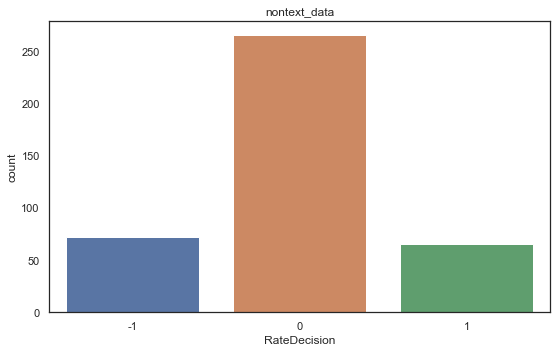

In [ ]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

## Correlation

In [ ]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 'PMI_date',
       'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 'NMI_date',
       'NMI_value', 'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date',
       'Rsales_value', 'Rsales_diff_prev', 'Rsales_diff_year',
       'Hsales_date', 'Hsales_value', 'Hsales_diff_prev',
       'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia', 'Taylor-Rate',
       'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff',
       'Inertia_diff', 'prev_decision'

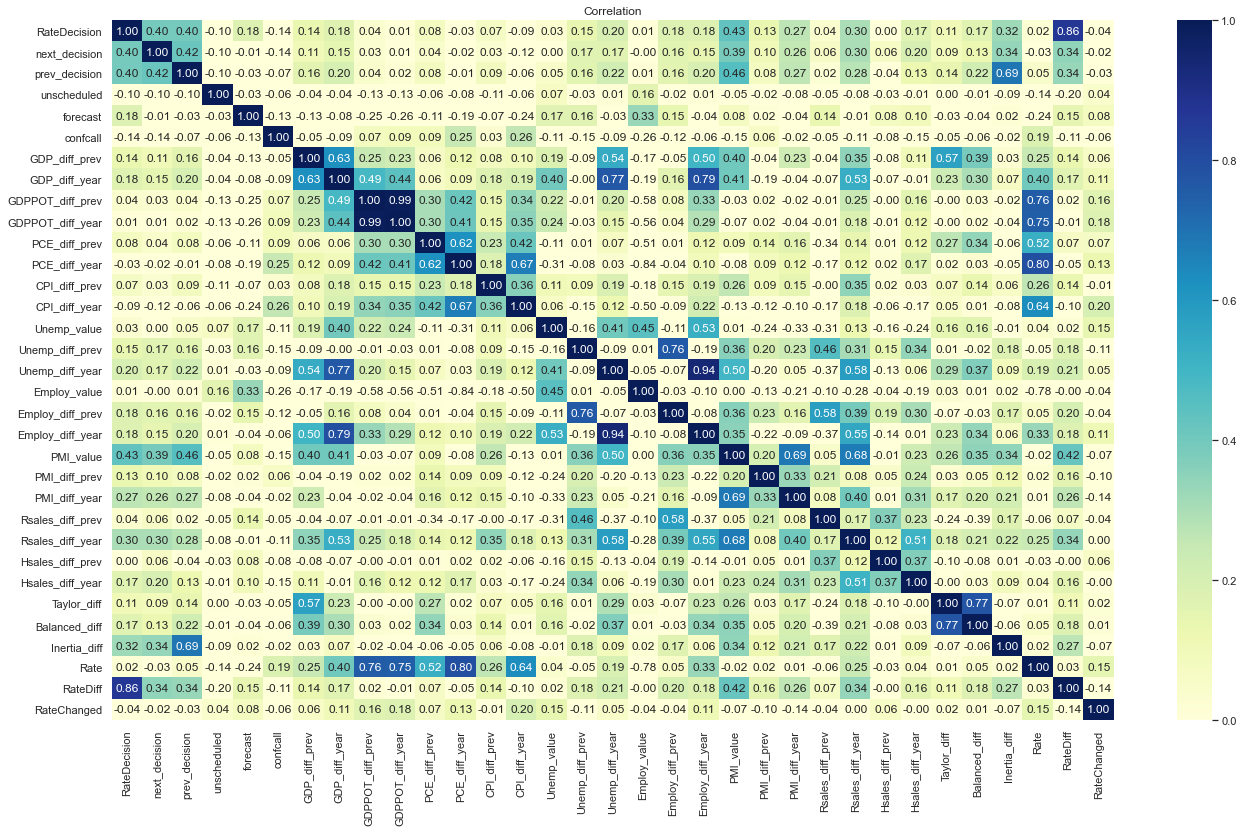

In [ ]:
# Per document type
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff', 'RateChanged']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

Observation on the correlation:

Higher correlation with Rate Decision:
 * 'GDP_diff_prev'
 * 'Unemp_diff_year'
 * 'Employ_diff_prev'
 * 'PMI_value'
 * 'Rsales_diff_year'
 * 'Hsales_diff_year'
 * 'prev_decision'
 * 'Taylor_diff'
 * 'Balanced_diff'
 * 'Inertia_diff'

Low correlation with Rate Decision:
 *  'unscheduled' - correlation is small
 * 'forecast' - logically not related
 * 'confcall' - correlation is small
 * 'GDP_diff_year' - use GDP_diff_prev instead, which highly correlate to this
 * 'GDPPOT_diff_prev' - correlation is small
 * 'GDPPOT_diff_year' - correlation is small
 * 'PCE_diff_prev' - correlation is small
 * 'PCE_diff_year' - correlation is small
 * 'CPI_diff_prev' - correlation is small
 * 'CPI_diff_year' - correlation is small
 * 'Unemp_value' - correlation is small
 * 'Unemp_diff_prev' - use Unemp_diff_year instead, which highly correlate to this
 * 'Employ_value' - correlation is small
 * 'Employ_diff_year' - use Employ_diff_prev instead, which highly correlate to this
 * 'PMI_diff_prev' - correlation is small
 * 'PMI_diff_year' - correlation is small
 * 'Rsales_diff_prev' - correlation is small
 * 'Rsales_diff_year' - correlation is small
 * 'Hsales_diff_prev' - correlation is small
 * 'Hsales_diff_year' - correlation is small
 * 'next_decision' - this was added to see whether there's any meaningful correlation from previous period

Will create two dataset, one full set and the other smaller set with high correlation

In [ ]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

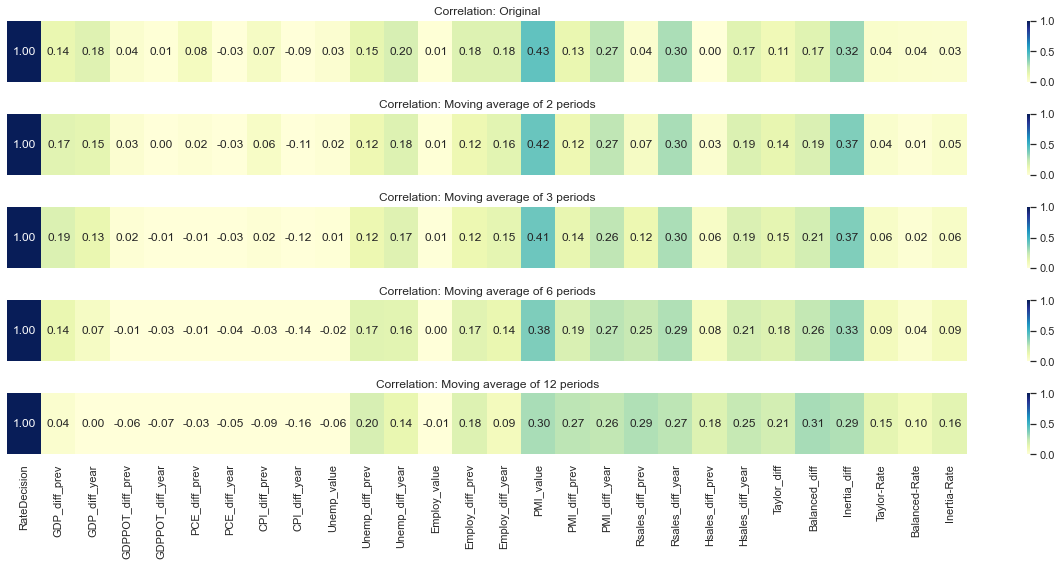

In [ ]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

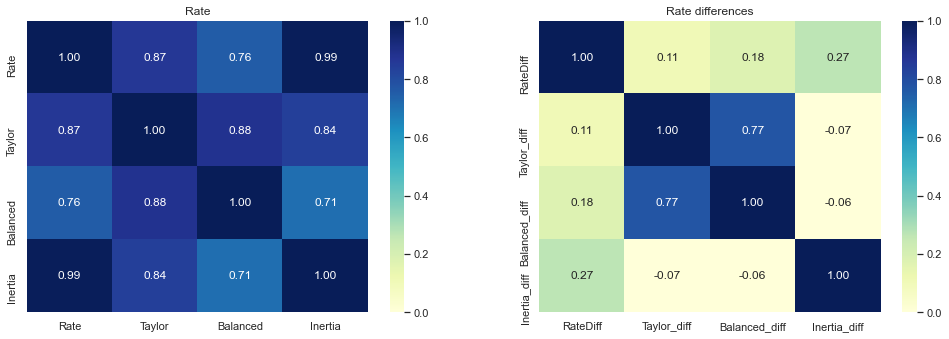

In [ ]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")

corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")

plt.show()

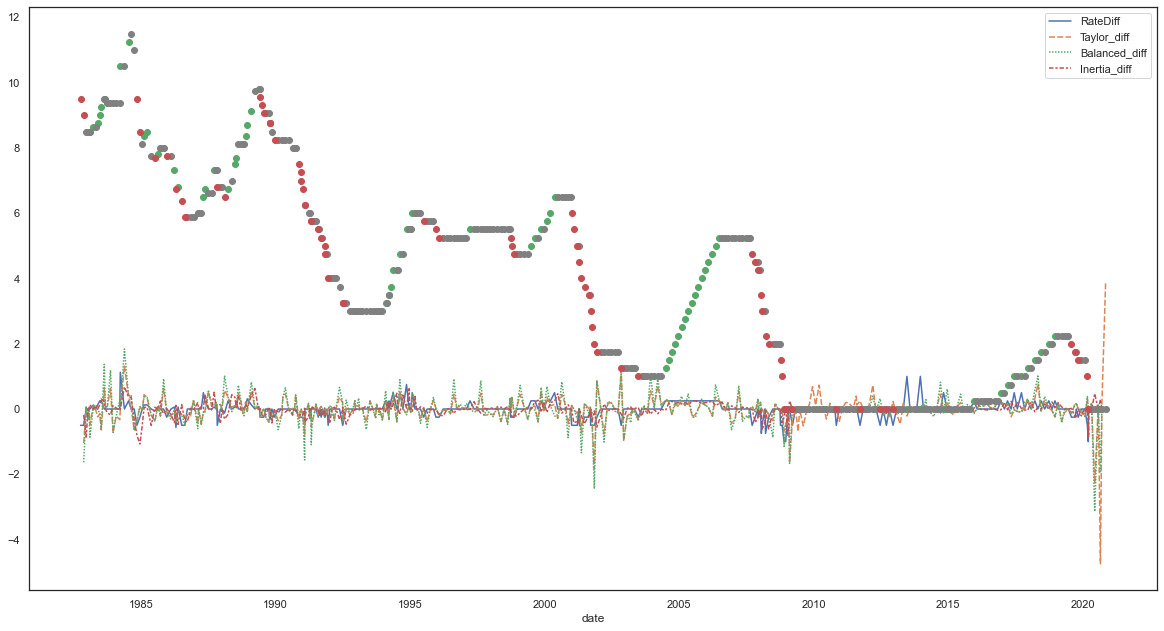

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")

## Checking Correlation of Individual Columns

This section has an endlist grahs depicting the correlation between various individual columns

In [ ]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)


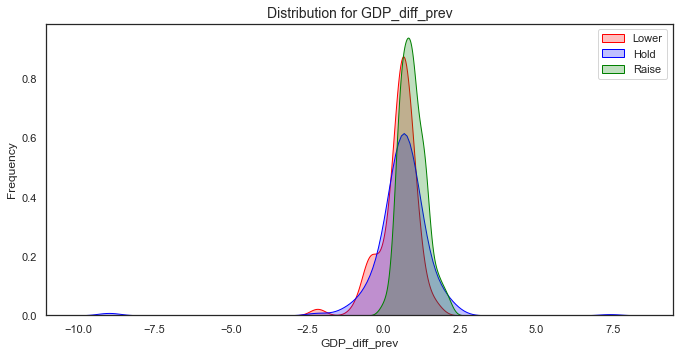

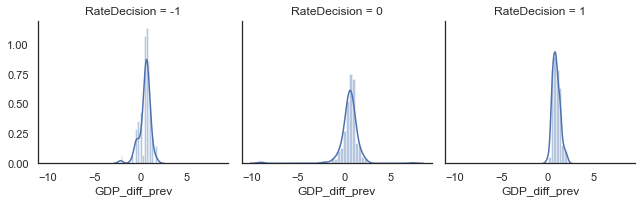

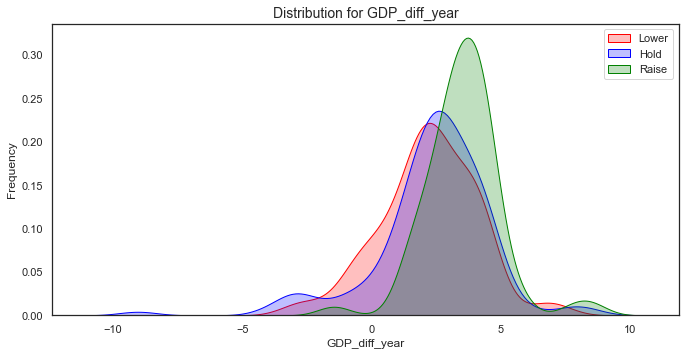

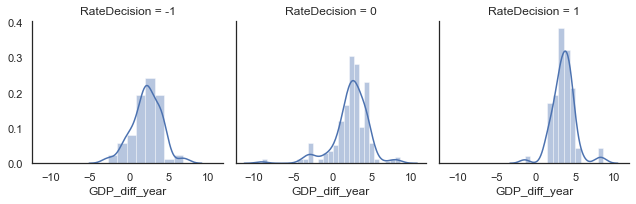

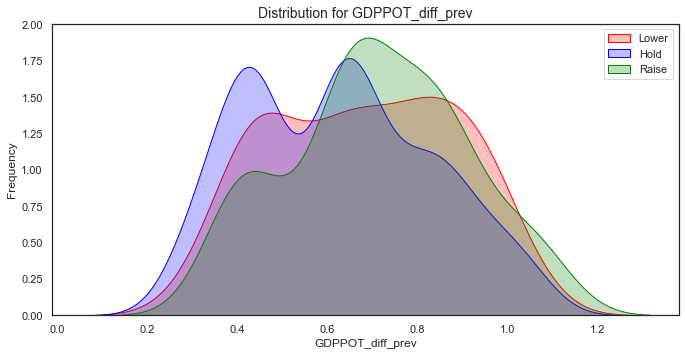

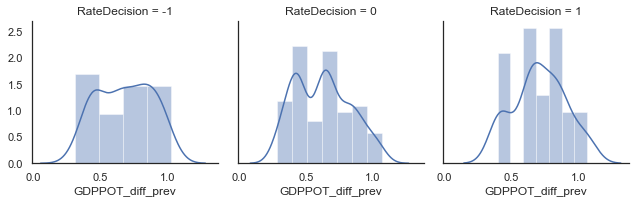

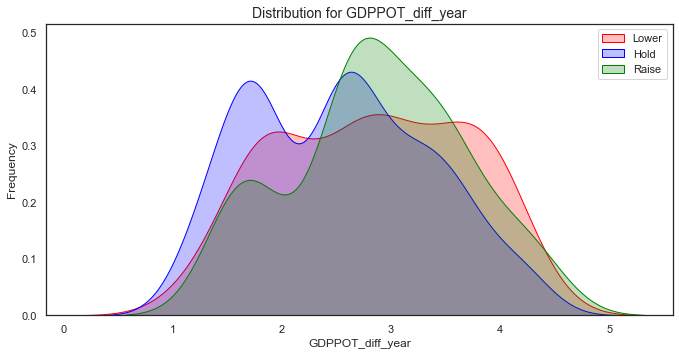

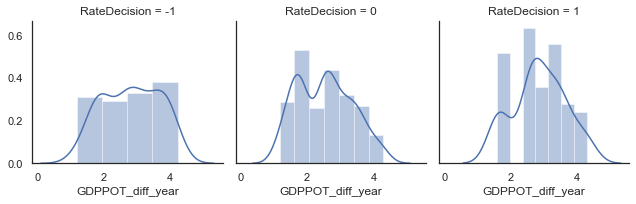

In [ ]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

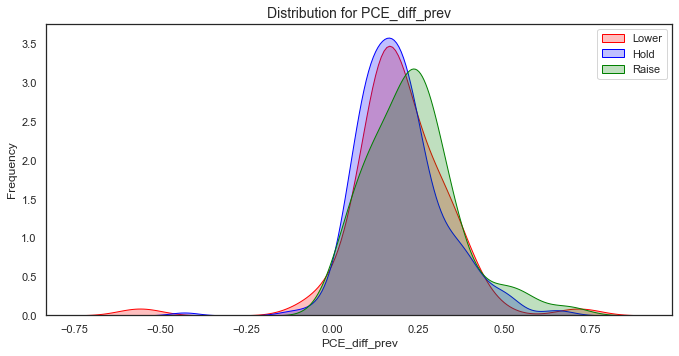

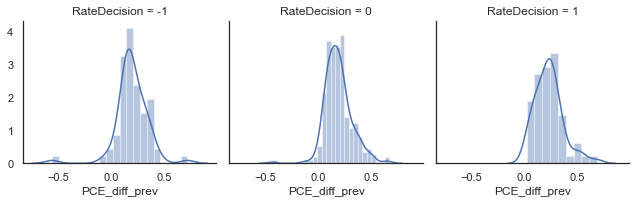

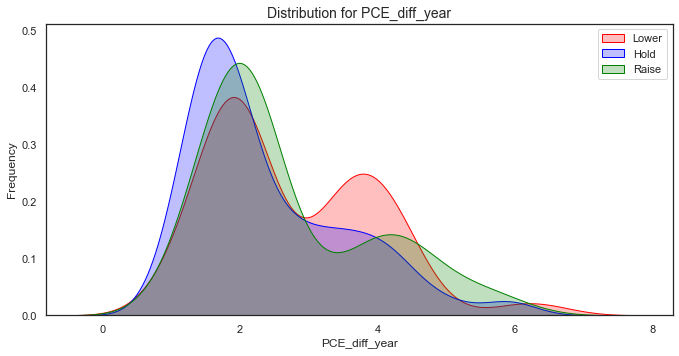

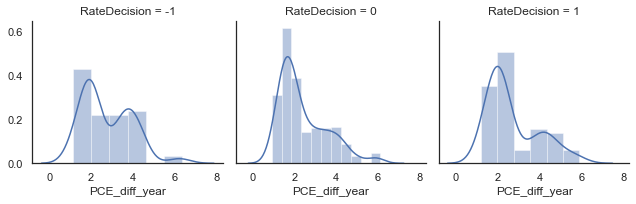

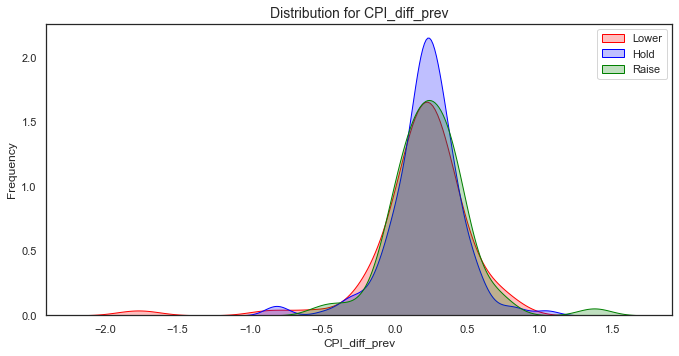

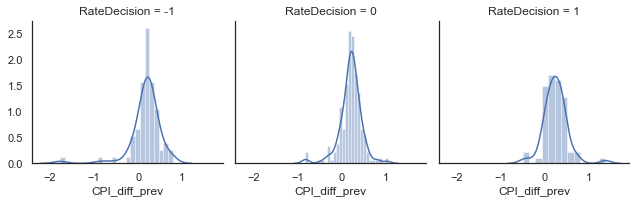

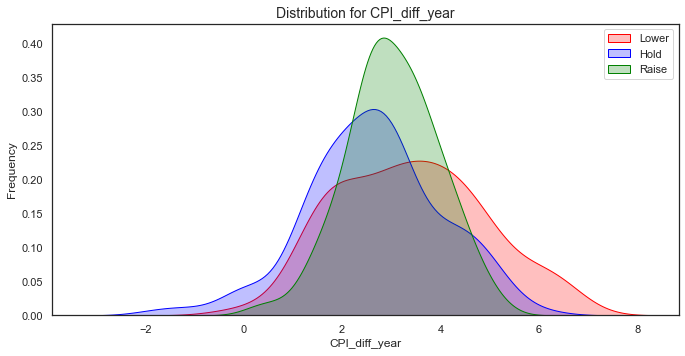

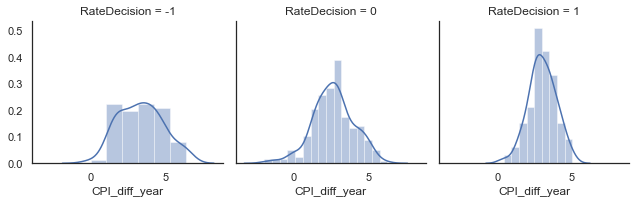

In [ ]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

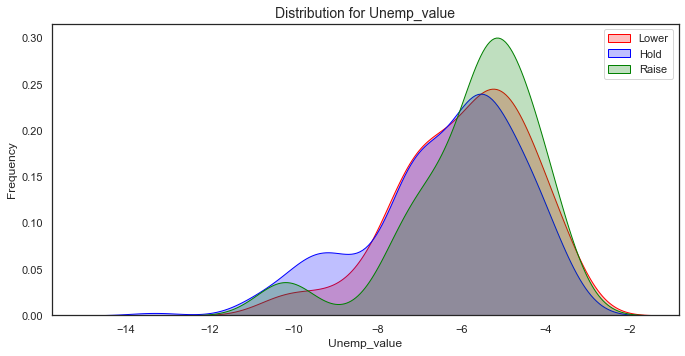

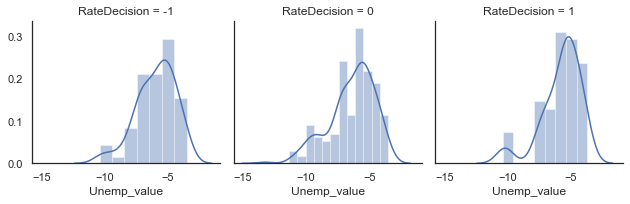

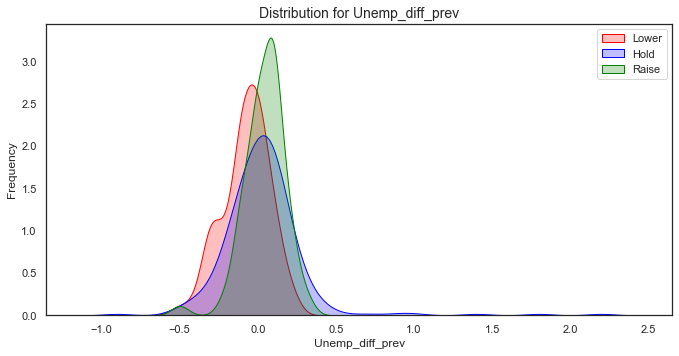

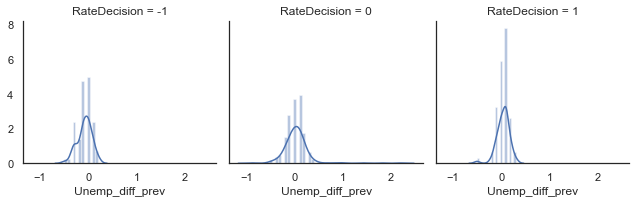

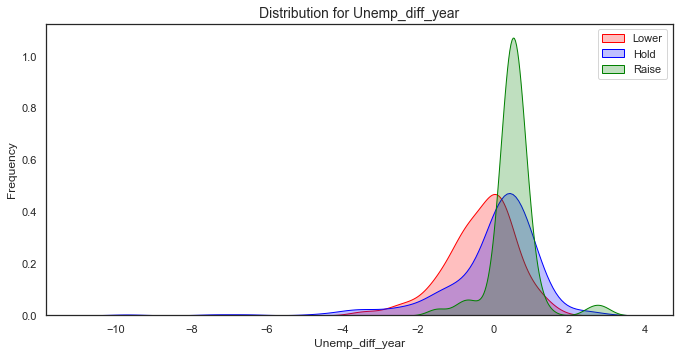

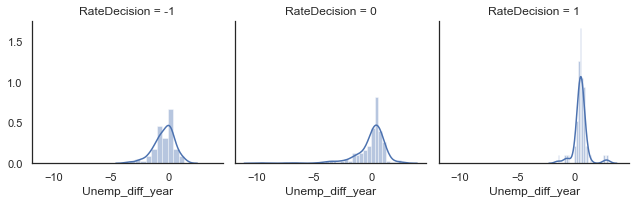

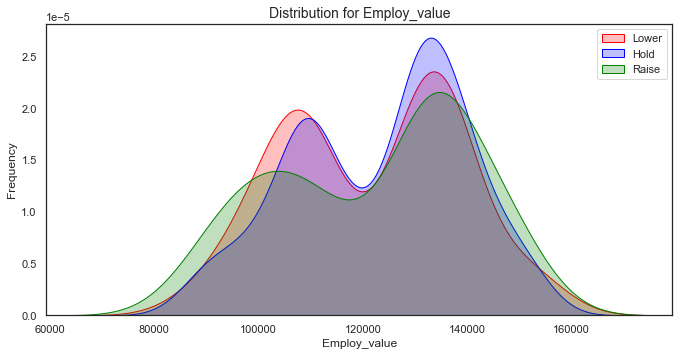

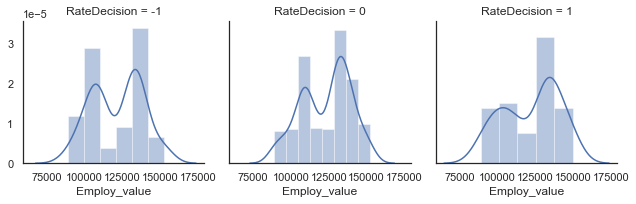

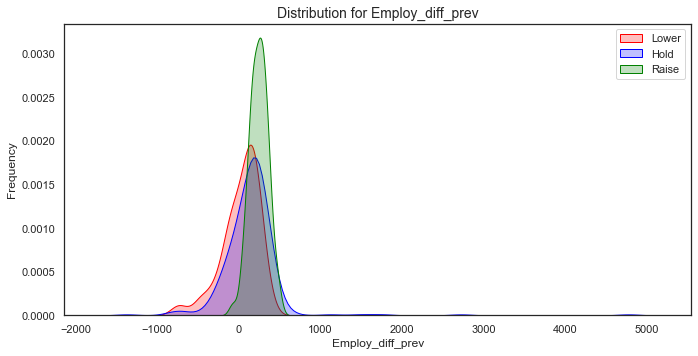

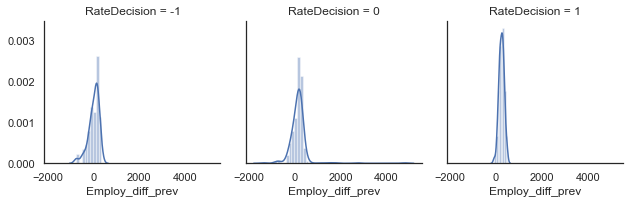

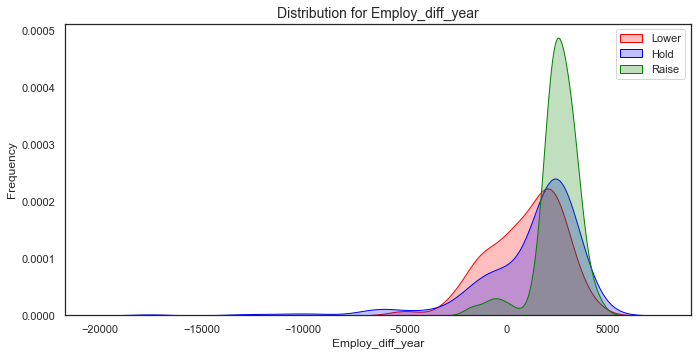

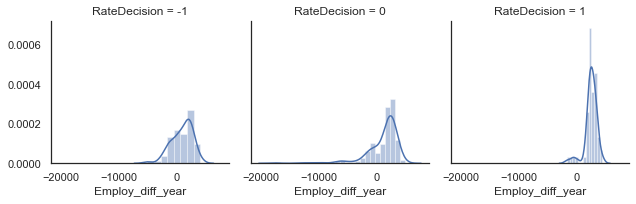

In [ ]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

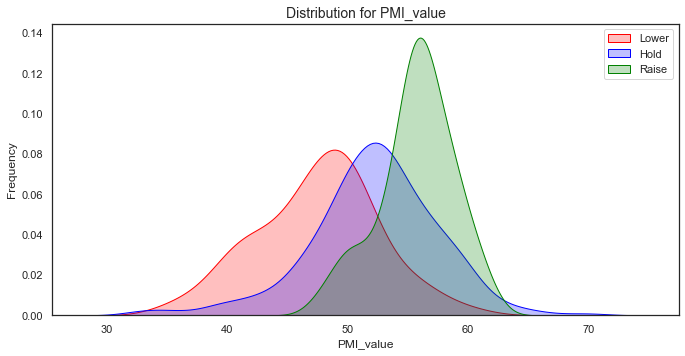

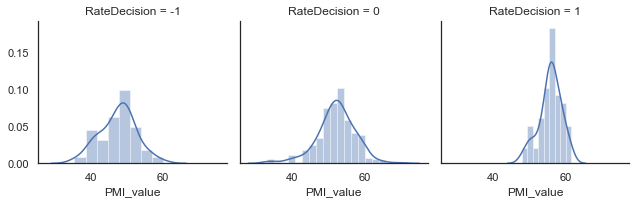

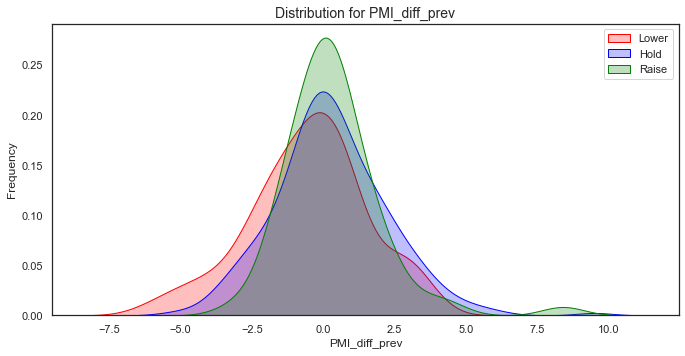

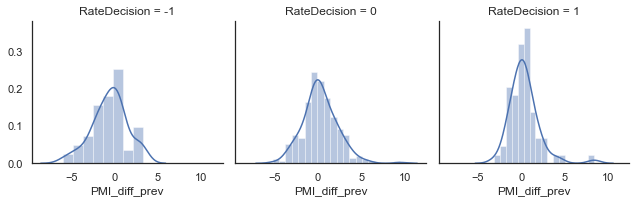

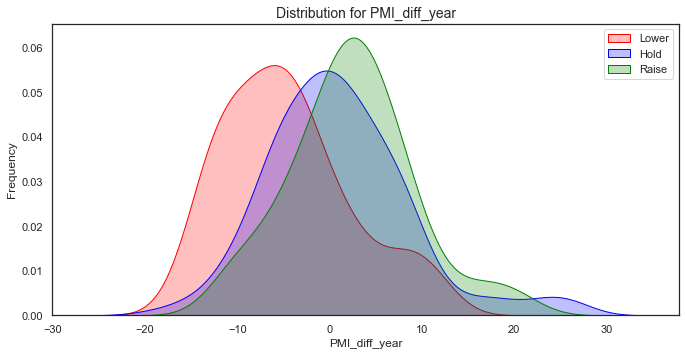

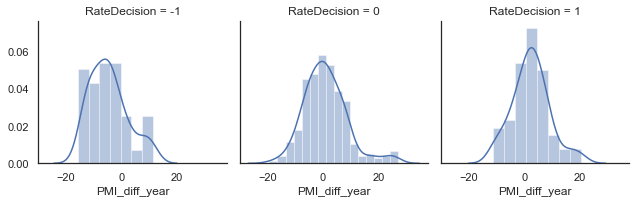

In [ ]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

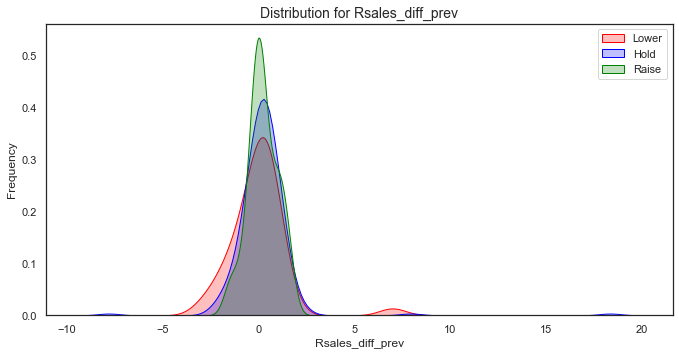

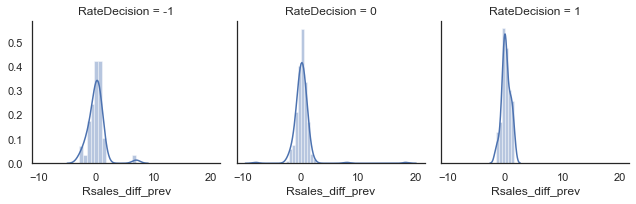

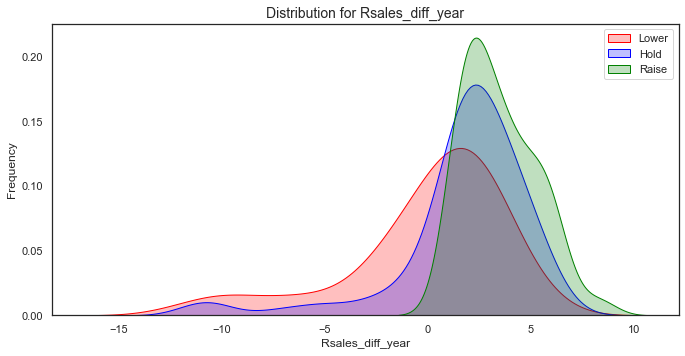

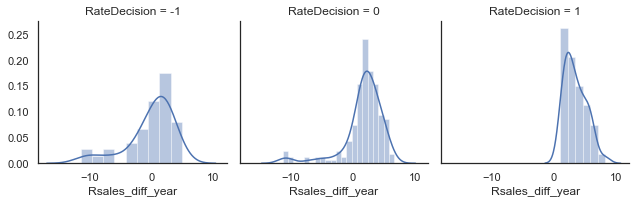

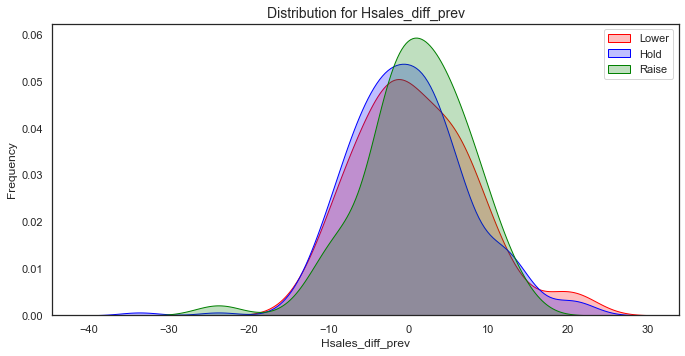

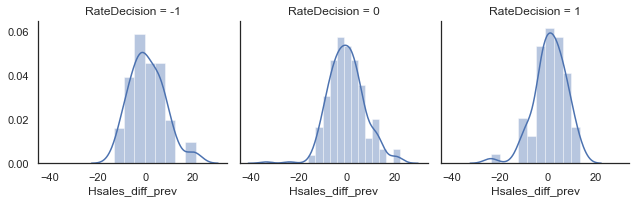

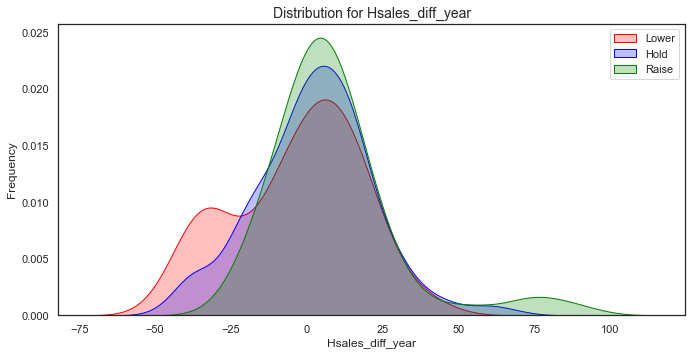

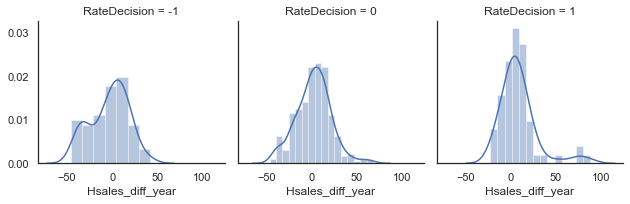

In [ ]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

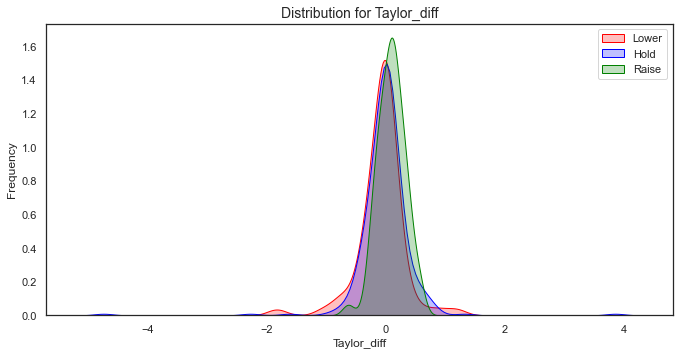

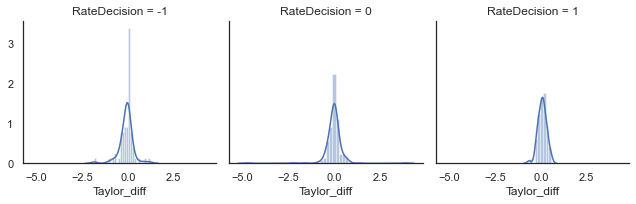

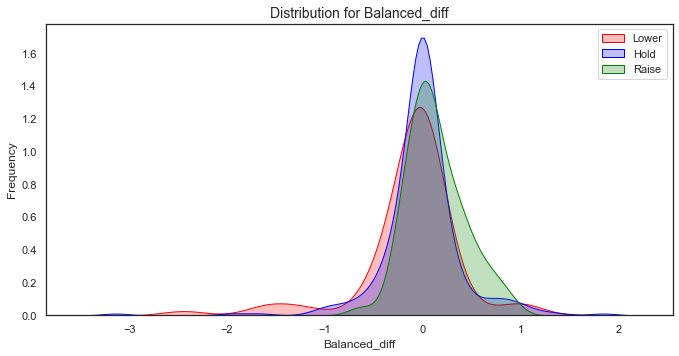

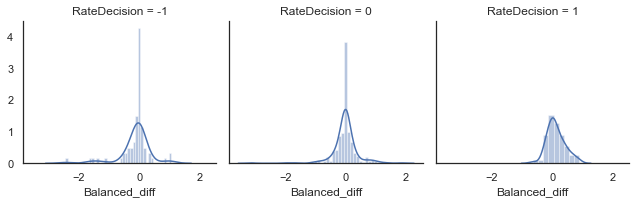

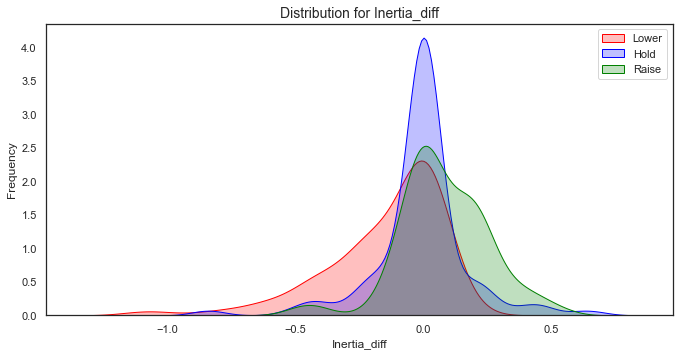

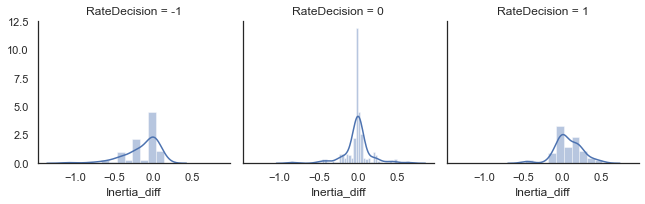

In [ ]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [ ]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']], 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']], 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']]], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [ ]:
nontext_train_small.isnull().sum()

target                0
prev_decision         1
GDP_diff_prev         0
PMI_value             0
Employ_diff_prev      0
Rsales_diff_year    131
Unemp_diff_prev       0
Inertia_diff          4
Hsales_diff_year      0
Balanced_diff        15
dtype: int64

In [ ]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(403, 29)
(403, 27)
(403, 56)


In [ ]:
nontext_train_large.isnull().sum()

target               0
prev_decision        1
GDP_diff_prev        0
GDP_diff_year        0
GDPPOT_diff_prev     0
                    ..
Balanced-Rate_ma3    3
Inertia-Rate_ma3     3
Taylor_diff_ma3      4
Balanced_diff_ma3    4
Inertia_diff_ma3     4
Length: 56, dtype: int64

### Missing Values

In [ ]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

(0.0, 400.0)

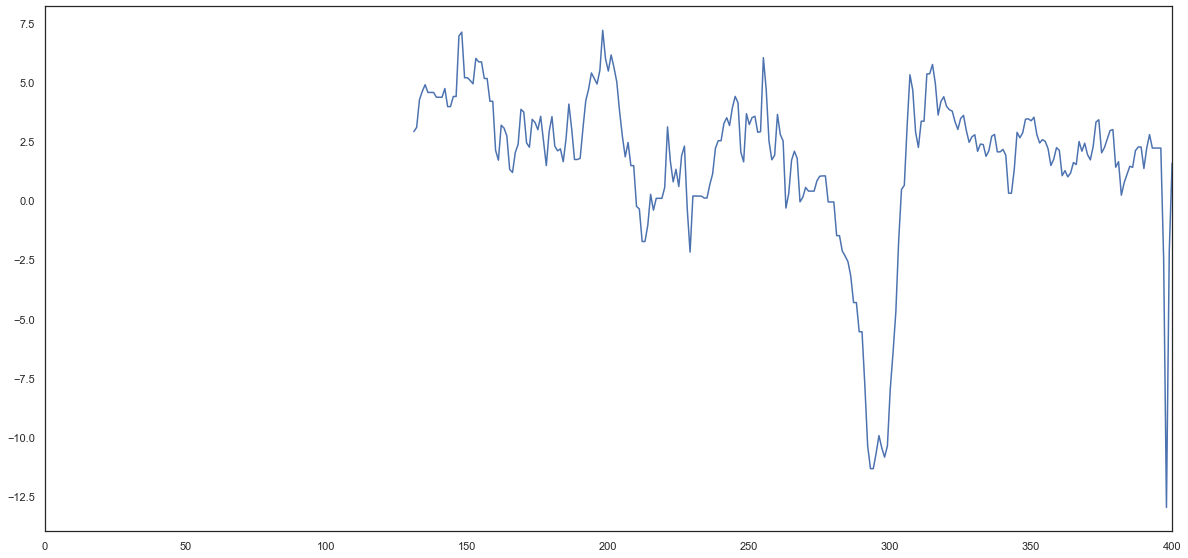

In [ ]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

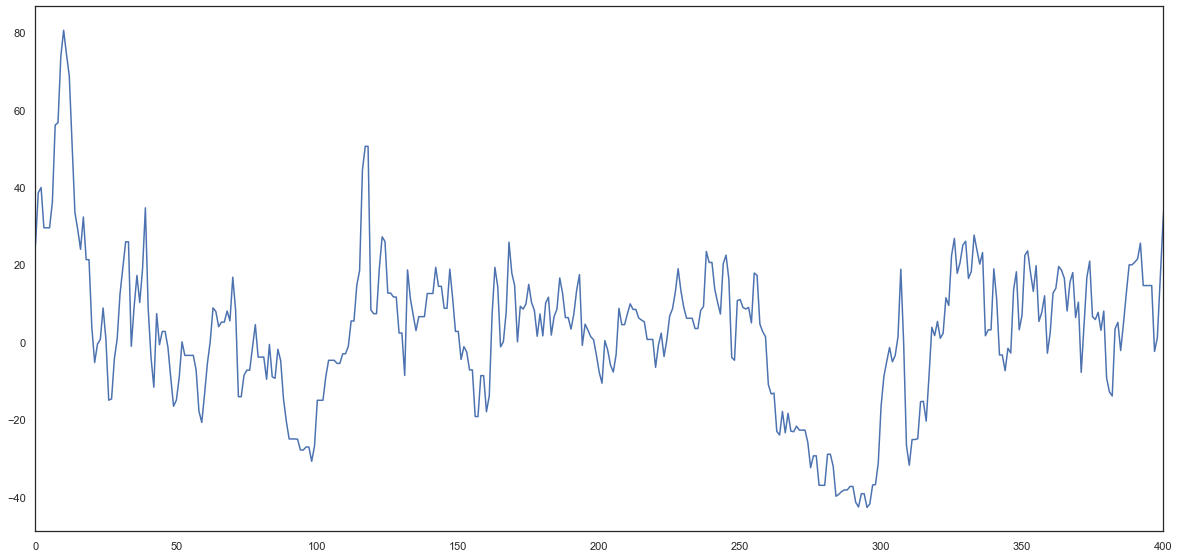

In [ ]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [ ]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)



In [ ]:
nontext_train_small.isnull().sum()

target              0
prev_decision       0
GDP_diff_prev       0
PMI_value           0
Employ_diff_prev    0
Rsales_diff_year    0
Unemp_diff_prev     0
Inertia_diff        0
Hsales_diff_year    0
Balanced_diff       0
dtype: int64

In [ ]:
nontext_train_large.isnull().sum()

target               0
prev_decision        0
GDP_diff_prev        0
GDP_diff_year        0
GDPPOT_diff_prev     0
                    ..
Balanced-Rate_ma3    0
Inertia-Rate_ma3     0
Taylor_diff_ma3      0
Balanced_diff_ma3    0
Inertia_diff_ma3     0
Length: 56, dtype: int64

## Save Data to pickle

In [ ]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')

In [ ]:
nontext_train_small

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05      -1              0       0.456197       38.8            -169.0   
1982-11-16      -1             -1      -0.382295       39.4            -228.0   
1982-12-21       0             -1      -0.382295       39.2            -198.5   
1983-01-14       0              0      -0.382295       42.8             -68.0   
1983-01-21       0              0      -0.382295       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          1.738830        -0.166667     -0.017862        -15.485275   
1982-11-16          1.738830        -0.200000     -0.017862         -9.537496   
1982-12-21          1.738830        -0.333333     -0.017862         -3.116275   
1983-01-14          1.738830        -0.233333     -0.017862         -0.774432   
1983-01-21          1.738830        -0.233333     -0.043808         -0.774432   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  
date                       
1982-10-05       0.000220  
1982-11-16       0.000220  
1982-12-21       0.000220  
1983-01-14       0.000220  
1983-01-21       0.000220  
...                   ...  
2020-06-10      -0.190738  
2020-07-29      -0.339976  
2020-08-27      -0.346179  
2020-09-16      -0.248988  
2020-11-05      -0.642625  

[403 rows x 10 columns]

# Preprocessing and EDA on Textual Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [ ]:
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [ ]:
# Python libraries
import datetime as dt
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter
import re
import pickle
from tqdm.notebook import tqdm


from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amruth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amruth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amruth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [ ]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [ ]:
preprocessed_dir = '../data/preprocessed/'
train_dir = '../data/train_data/'
output_dir = '../data/result/'
lmdict_dir = '../data/LoughranMcDonald/'
glove_dir = '../data/GloVe'

In [ ]:
# Load previously processed non-text data
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df

(403, 10)


target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05      -1              0       0.456197       38.8            -169.0   
1982-11-16      -1             -1      -0.382295       39.4            -228.0   
1982-12-21       0             -1      -0.382295       39.2            -198.5   
1983-01-14       0              0      -0.382295       42.8             -68.0   
1983-01-21       0              0      -0.382295       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          1.738830        -0.166667     -0.017862        -15.485275   
1982-11-16          1.738830        -0.200000     -0.017862         -9.537496   
1982-12-21          1.738830        -0.333333     -0.017862         -3.116275   
1983-01-14          1.738830        -0.233333     -0.017862         -0.774432   
1983-01-21          1.738830        -0.233333     -0.043808         -0.774432   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  
date                       
1982-10-05       0.000220  
1982-11-16       0.000220  
1982-12-21       0.000220  
1983-01-14       0.000220  
1983-01-21       0.000220  
...                   ...  
2020-06-10      -0.190738  
2020-07-29      -0.339976  
2020-08-27      -0.346179  
2020-09-16      -0.248988  
2020-11-05      -0.642625  

[403 rows x 10 columns]

In [ ]:
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [ ]:
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()


file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

## Check the statistics of text data using bar plots

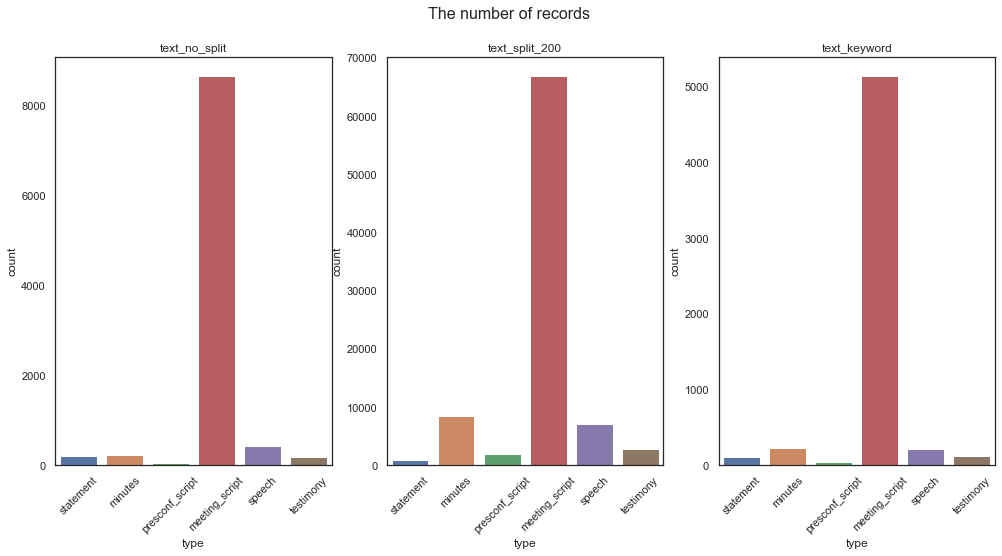

In [ ]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The number of records", fontsize=16)
plt.show()



In [ ]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

type       date                    title  \
478  meeting_script 1982-10-05  FOMC Meeting Transcript   
479  meeting_script 1982-10-05  FOMC Meeting Transcript   
480  meeting_script 1982-10-05  FOMC Meeting Transcript   
481  meeting_script 1982-10-05  FOMC Meeting Transcript   
482  meeting_script 1982-10-05  FOMC Meeting Transcript   

                                            speaker  word_count decision rate  \
478                               CHAIRMAN  VOLCKER        3596       -1  9.5   
479  CHAIRMAN  VOLCKER.  It  was  a  group  of  ABA         686       -1  9.5   
480                                CHAIRMAN VOLCKER        6153       -1  9.5   
481                                    MR.  AXILROD         544       -1  9.5   
482                                     MR.  BALLES         545       -1  9.5   

    next_meeting next_decision  next_rate  \
478   1982-11-16            -1        9.0   
479   1982-11-16            -1        9.0   
480   1982-11-16            -1        9.0   
481   1982-11-16            -1        9.0   
482   1982-11-16            -1        9.0   

                                                                                                                                                                                                        text  
478   I  thought  it  had  been  level  for  a  longwhile but  it  may  be  that  it  got  back  to  where  it  was  a  year  ago.  Itsurprised  me  that  they  were  up  that  much  in  a  year. Well,...  
479  bankers,  but  that'sincidental.  It  is  going  on.  That  is  why  all  these  South  Americancountries  together  suddenly  can't  find  financing  or  financing  inanywhere  near  the  volume ...  
480   Well,  I want  to  come  back to  some  of  thesequestions  later.  I think  it's  better  to  take  them up  later  in  thecontext  of  the  whole  policy  problem.  But  immediately,  we  inter...  
481   If  there  were  not  a specification  for  M1  andthere were  for  M2  or  M3,  we  would  draw  them  on  the  basis  of  the  M2  orM3  specifications  and  we  would  draw an  M1  path,  unle...  
482   Well,  coming  at  this  confidence  factor  from  alittle  different  direction,  since  as  we  all  know  both  consumerconfidence  and  business  confidence  do  play  a key  part  in  what  ...

There are many meeting scripts but we do not use them this time as they cannot be used for prediction of the rate decision because meeting scripts are published four years after the meeting.

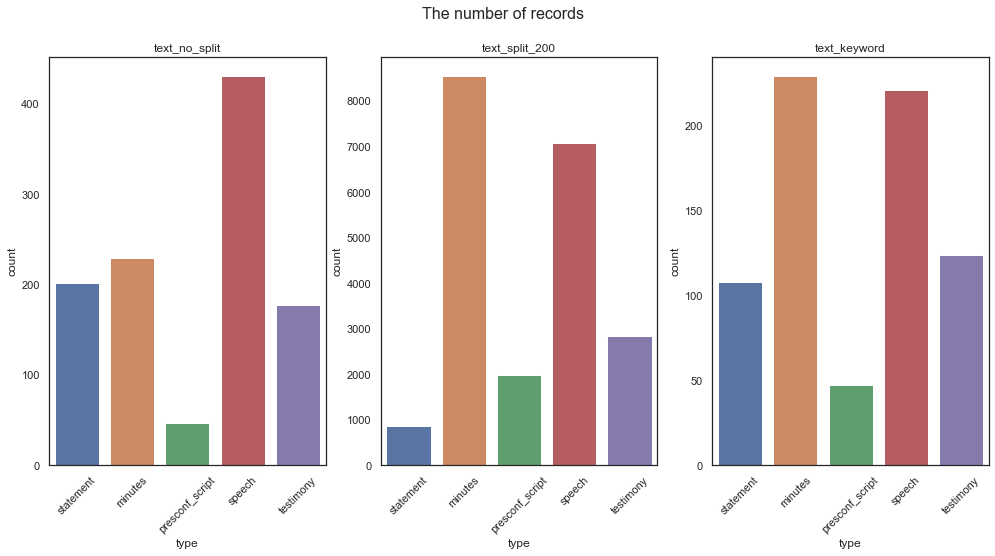

In [ ]:
# Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The number of records", fontsize=16)
plt.show()

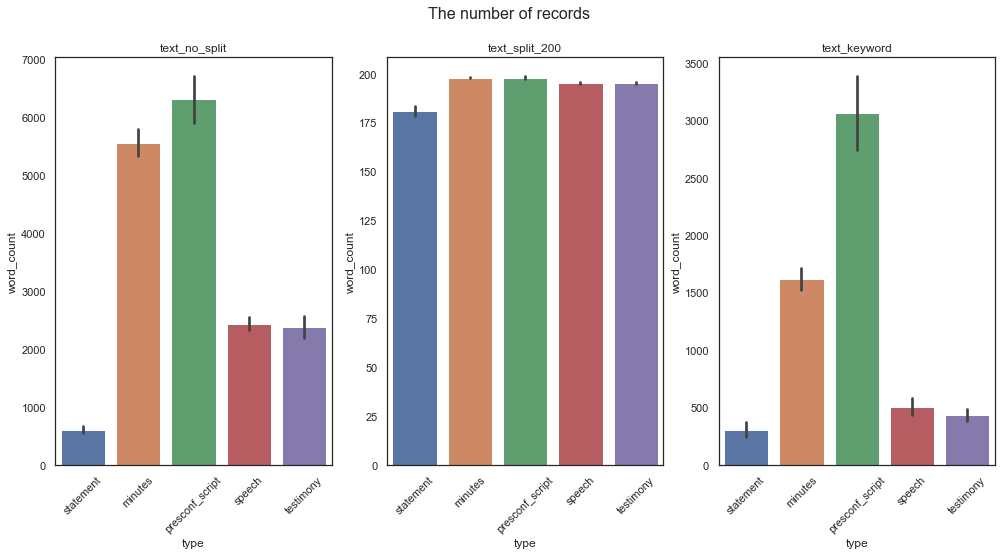

In [ ]:
# Check the number of words per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.barplot(data=text_no_split, x='type', y='word_count', ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The number of records", fontsize=16)
plt.show()

In [ ]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(1085, 11)


type       date  \
0     statement 1994-02-04   
1     statement 1994-03-22   
2     statement 1994-04-18   
3     statement 1994-05-17   
4     statement 1994-08-16   
...         ...        ...   
1080  testimony 2020-02-11   
1081  testimony 2020-05-19   
1082  testimony 2020-06-16   
1083  testimony 2020-06-30   
1084  testimony 2020-09-22   

                                                   title         speaker  \
0                                         FOMC Statement  Alan Greenspan   
1                                         FOMC Statement  Alan Greenspan   
2                                         FOMC Statement  Alan Greenspan   
3                                         FOMC Statement  Alan Greenspan   
4                                         FOMC Statement  Alan Greenspan   
...                                                  ...             ...   
1080   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1081                           Coronavirus and CARES Act   Jerome Powell   
1082   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1083                           Coronavirus and CARES Act   Jerome Powell   
1084  Coronavirus Aid, Relief, and Economic Security Act   Jerome Powell   

      word_count decision  rate next_meeting next_decision  next_rate  \
0             99        1  3.25   1994-02-28             0       3.25   
1             40        1   3.5   1994-04-18             1       3.75   
2             37        1  3.75   1994-05-17             1       4.25   
3             57        1  4.25   1994-07-06             0       4.25   
4             51        1  4.75   1994-09-27             0       4.75   
...          ...      ...   ...          ...           ...        ...   
1080        1171     <NA>  None   2020-03-03            -1       1.00   
1081        1802     <NA>  None   2020-06-10             0       0.00   
1082        1433     <NA>  None   2020-07-29             0       0.00   
1083        2759     <NA>  None   2020-07-29             0       0.00   
1084        2400     <NA>  None   2020-11-05             0       0.00   

                                                                                                                                                                                                         text  
0     Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...  
1     Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...  
2     Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...  
3     In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...  
4     In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...  
...                                                                                                                                                                                                       ...  
1080  My colleagues and I strongly support the goals of maximum employment and price stability that Congress has set for monetary policy. Congress has given us an important degree of independence to pur...  
1081  I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world. The coronavirus outbreak is, 

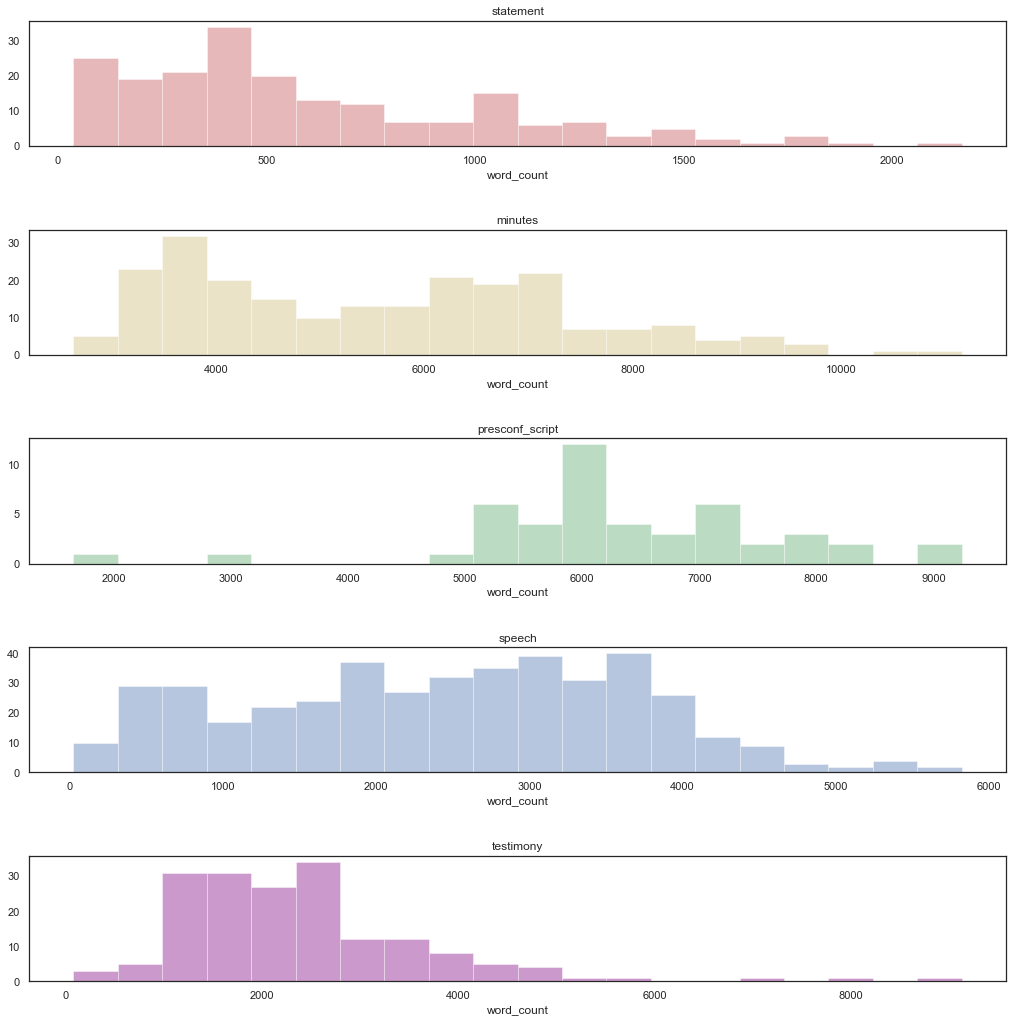

In [ ]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

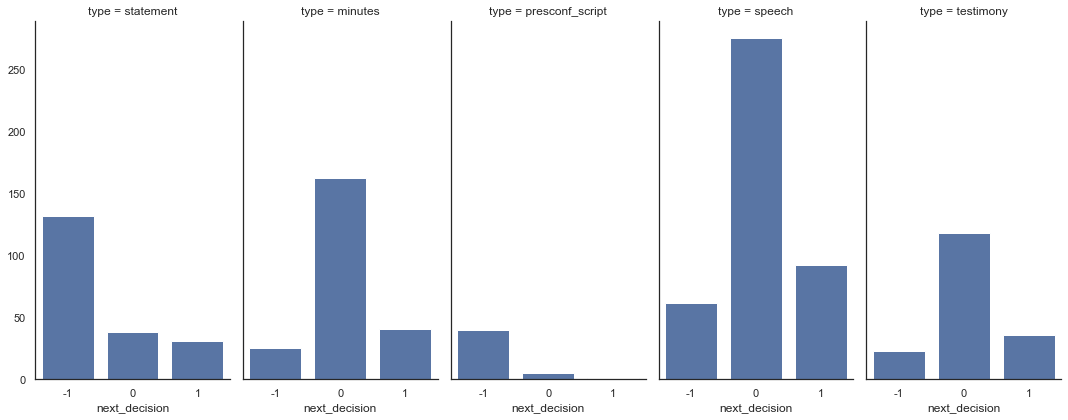

In [ ]:
g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()

The label is highly biased to 0(Hold). Need to consider how to mitigate the biased data.

## Merge text to the train dataframe

In [ ]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [ ]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05      -1              0       0.456197       38.8            -169.0   
1982-11-16      -1             -1      -0.382295       39.4            -228.0   
1982-12-21       0             -1      -0.382295       39.2            -198.5   
1983-01-14       0              0      -0.382295       42.8             -68.0   
1983-01-21       0              0      -0.382295       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          1.738830        -0.166667     -0.017862        -15.485275   
1982-11-16          1.738830        -0.200000     -0.017862         -9.537496   
1982-12-21          1.738830        -0.333333     -0.017862         -3.116275   
1983-01-14          1.738830        -0.233333     -0.017862         -0.774432   
1983-01-21          1.738830        -0.233333     -0.043808         -0.774432   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  \
date                        
1982-10-05       0.000220   
1982-11-16       0.000220   
1982-12-21       0.000220   
1983-01-14       0.000220   
1983-01-21       0.000220   
...                   ...   
2020-06-10      -0.190738   
2020-07-29      -0.339976   
2020-08-27      -0.346179   
2020-09-16      -0.248988   
2020-11-05      -0.642625   

                                                                                                                                                                                                          statement  \
date                                                                                                                                                                                                                  
1982-10-05                                                                                                                                                                                                            
1982-11-16                                                                                                                                                                                                            
1982-12-21                                                                                                                                                                                                            
1983-01-14                                                                                                                                                                                                            
1983-01-21                                                                                                                                                                                                            
...                  

In [ ]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

123977 words in original text for statement
123637 words in merged text for statement
1270696 words in original text for minutes
1270696 words in merged text for minutes
286524 words in original text for presconf_script
283637 words in merged text for presconf_script
1044550 words in original text for speech
1044550 words in merged text for speech
418890 words in original text for testimony
418890 words in merged text for testimony
Total: 3144637 words in original text
Total: 3141410 words in merged text
Total: 3141410 words in text column of merged text


In [ ]:
doc_types

array(['statement', 'minutes', 'presconf_script', 'speech', 'testimony'],
      dtype=object)

In [ ]:
print("Before dropping: ", train_df.shape)
train_df = train_df.loc[train_df['text'] != ""]
print("After dropping: ", train_df.shape)

Before dropping:  (403, 16)
After dropping:  (250, 16)


## Explore the text data and basic text preprocessing
In the below we will be performing some preprocessing of the text data, such as retreiving the stop words and non stop words

In [ ]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [ ]:
corpus = create_corpus(text_df)

In [ ]:
x, y = get_frequent_stop_words(corpus)

In [ ]:
print(x)
print(y)

('the', 'of', 'in', 'to', 'and', 'a', 'that', 'for', 'on', 'as')
(215838, 117259, 98102, 94058, 91804, 49097, 47652, 33259, 23833, 22930)


In [ ]:
x, y = get_frequent_nonstop_words(corpus)

In [ ]:
print(x)
print(y)

('economic', 'financial', 'federal', 'inflation', 'market', 'would', 'rate', 'policy', 'growth', 'committee')
(14416, 13640, 13391, 12791, 11434, 11278, 10594, 10202, 9233, 8120)


<AxesSubplot:>

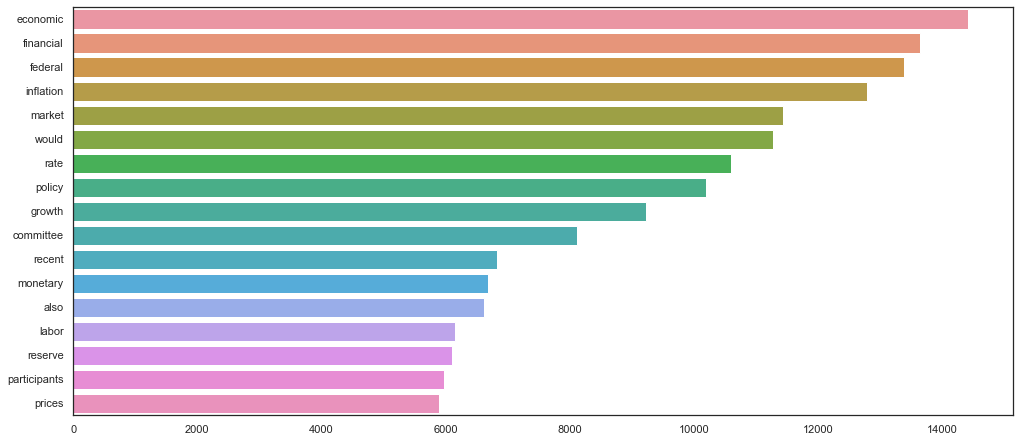

In [ ]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

## Generating Word Cloud Image

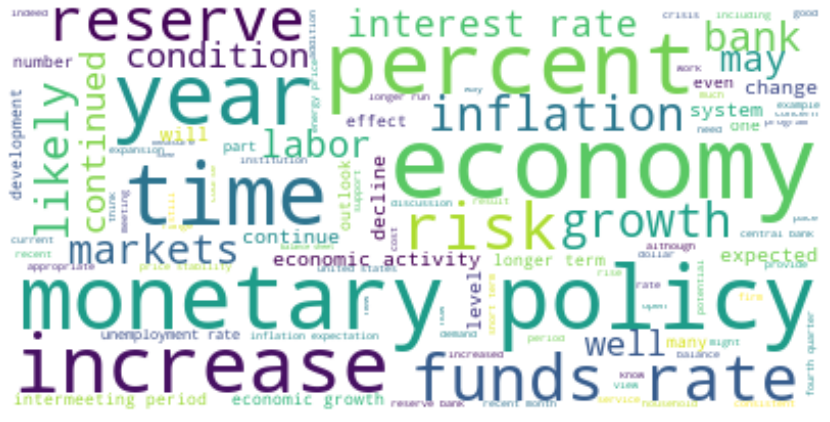

In [ ]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)



## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).

In [ ]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


word     sentiment
0            ABANDON      Negative
1          ABANDONED      Negative
2         ABANDONING      Negative
3        ABANDONMENT      Negative
4       ABANDONMENTS      Negative
...              ...           ...
4135        STRICTER  Constraining
4136       STRICTEST  Constraining
4137        STRICTLY  Constraining
4138  UNAVAILABILITY  Constraining
4139     UNAVAILABLE  Constraining

[4140 rows x 2 columns]

In [ ]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   184
Litigious      904
Negative      2355
Positive       354
StrongModal     19
Uncertainty    297
WeakModal       27

In [ ]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [ ]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [ ]:
# Analyze tone for original text dataframe
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df

(1085, 11)


type       date  \
0     statement 1994-02-04   
1     statement 1994-03-22   
2     statement 1994-04-18   
3     statement 1994-05-17   
4     statement 1994-08-16   
...         ...        ...   
1080  testimony 2020-02-11   
1081  testimony 2020-05-19   
1082  testimony 2020-06-16   
1083  testimony 2020-06-30   
1084  testimony 2020-09-22   

                                                   title         speaker  \
0                                         FOMC Statement  Alan Greenspan   
1                                         FOMC Statement  Alan Greenspan   
2                                         FOMC Statement  Alan Greenspan   
3                                         FOMC Statement  Alan Greenspan   
4                                         FOMC Statement  Alan Greenspan   
...                                                  ...             ...   
1080   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1081                           Coronavirus and CARES Act   Jerome Powell   
1082   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1083                           Coronavirus and CARES Act   Jerome Powell   
1084  Coronavirus Aid, Relief, and Economic Security Act   Jerome Powell   

      word_count decision  rate next_meeting next_decision  next_rate  \
0             99        1  3.25   1994-02-28             0       3.25   
1             40        1   3.5   1994-04-18             1       3.75   
2             37        1  3.75   1994-05-17             1       4.25   
3             57        1  4.25   1994-07-06             0       4.25   
4             51        1  4.75   1994-09-27             0       4.75   
...          ...      ...   ...          ...           ...        ...   
1080        1171     <NA>  None   2020-03-03            -1       1.00   
1081        1802     <NA>  None   2020-06-10             0       0.00   
1082        1433     <NA>  None   2020-07-29             0       0.00   
1083        2759     <NA>  None   2020-07-29             0       0.00   
1084        2400     <NA>  None   2020-11-05             0       0.00   

                                                                                                                                                                                                         text  \
0     Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...   
1     Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...   
2     Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...   
3     In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...   
4     In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...   
...                                                                                                                                                                                                       ...   
1080  My colleagues and I strongly support the goals of maximum employment and price stability that Congress has set for monetary policy. Congress has given us an important degree of independence to pur...   
1081  I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world. The coronavirus outbr

In [ ]:
# Analyze tone for training dataframe


tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)
    
train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1993-02-18       0              0       1.043165       55.8             261.0   
1993-05-18       0              0       0.167400       50.2             126.0   
1993-07-07       0              0       0.167400       49.6             226.5   
1993-08-17       0              0       0.582420       50.2             243.5   
1993-09-21       0              0       0.582420       50.7             228.5   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1993-02-18          1.738830         0.000000     -0.015867         14.901418   
1993-05-18          3.092456         0.066667     -0.000577         13.455236   
1993-07-07          4.263357         0.000000      0.050161         13.446869   
1993-08-17          4.611673         0.066667      0.002073         11.927296   
1993-09-21          4.894733         0.100000     -0.006598         10.302509   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  \
date                        
1993-02-18       0.035737   
1993-05-18       0.110562   
1993-07-07      -0.016758   
1993-08-17       0.028077   
1993-09-21      -0.011247   
...                   ...   
2020-06-10      -0.190738   
2020-07-29      -0.339976   
2020-08-27      -0.346179   
2020-09-16      -0.248988   
2020-11-05      -0.642625   

                                                                                                                                                                                                          statement  \
date                                                                                                                                                                                                                  
1993-02-18                                                                                                                                                                                                            
1993-05-18                                                                                                                                                                                                            
1993-07-07                                                                                                                                                                                                            
1993-08-17                                                                                                                                                                                                            
1993-09-21                                                                                                                                                                                                            
...                  

## Tokenize and vectorize

In [ ]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it lower case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized

## Tokenize text_df

In [ ]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])


len(tokenized_org):  1085
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [ ]:
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  1085
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early


In [ ]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

len(all_words_org):  1853186
chairman
len(counts_org):  20511
bow_org[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'financial', 'policy', 'price', 'federal', 'bank', 'committee', 'would', 'increase', 'growth', 'year', 'in', 'continue', 'economy', 'reserve', 'i']
vocab_org['chairman']:  1
vocab_org['market']:  8


In [ ]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

1085


In [ ]:
# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

## Tokenize train_df

In [ ]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))


len(tokenized):  250
['the', 'secretary', 'report', 'advice', 'election', 'reserve', 'bank', 'member', 'alternate', 'member', 'federal', 'open', 'market', 'committee', 'period', 'commence', 'january', 'end', 'december', 'receive', 'individual', 'execute', 'oath', 'office', 'the', 'elect', 'member', 'alternate', 'member', 'follow', 'by', 'unanimous', 'vote', 'committee', 'elect', 'follow', 'officer', 'federal', 'open', 'market', 'committee', 'serve', 'election', 'successor', 'first', 'meet', 'committee', 'december', 'understand', 'event', 'discontinuance', 'official', 'connection', 'board', 'governor', 'federal', 'reserve', 'bank', 'would', 'cease', 'official', 'connection', 'federal', 'open', 'market', 'committee', 'by', 'unanimous', 'vote', 'william', 'mcdonough', 'margaret', 'greene', 'joan', 'lovett', 'select', 'serve', 'pleasure', 'committee', 'capacity', 'manager', 'system', 'open', 'market', 'account', 'deputy', 'manager', 'foreign', 'operation', 'system', 'open', 'market', 'acc

len(counts):  20508
bow[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'financial', 'policy', 'price', 'federal', 'bank', 'committee', 'would', 'increase', 'growth', 'year', 'in', 'continue', 'economy', 'reserve', 'i']
250


<AxesSubplot:xlabel='tokenized_text', ylabel='Density'>

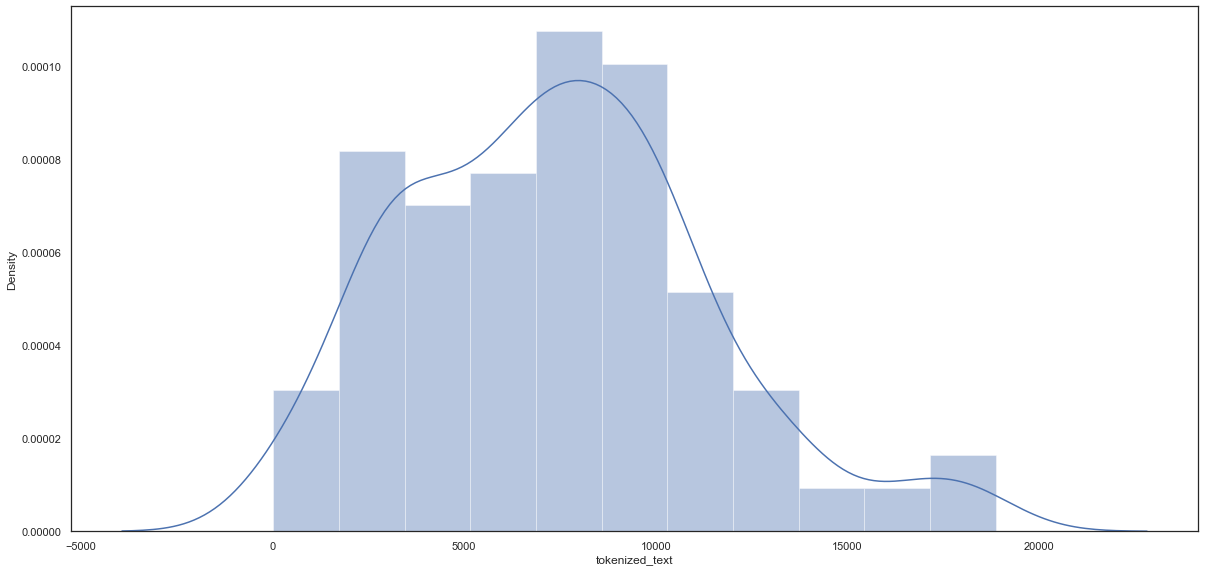

In [ ]:
sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))

In [ ]:
train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1993-02-18       0              0       1.043165       55.8             261.0   
1993-05-18       0              0       0.167400       50.2             126.0   
1993-07-07       0              0       0.167400       49.6             226.5   
1993-08-17       0              0       0.582420       50.2             243.5   
1993-09-21       0              0       0.582420       50.7             228.5   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1993-02-18          1.738830         0.000000     -0.015867         14.901418   
1993-05-18          3.092456         0.066667     -0.000577         13.455236   
1993-07-07          4.263357         0.000000      0.050161         13.446869   
1993-08-17          4.611673         0.066667      0.002073         11.927296   
1993-09-21          4.894733         0.100000     -0.006598         10.302509   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  \
date                        
1993-02-18       0.035737   
1993-05-18       0.110562   
1993-07-07      -0.016758   
1993-08-17       0.028077   
1993-09-21      -0.011247   
...                   ...   
2020-06-10      -0.190738   
2020-07-29      -0.339976   
2020-08-27      -0.346179   
2020-09-16      -0.248988   
2020-11-05      -0.642625   

                                                                                                                                                                                                          statement  \
date                                                                                                                                                                                                                  
1993-02-18                                                                                                                                                                                                            
1993-05-18                                                                                                                                                                                                            
1993-07-07                                                                                                                                                                                                            
1993-08-17                                                                                                                                                                                                            
1993-09-21                                                                                                                                                                                                            
...                  

## Lemmatize sentiment

In [ ]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [ ]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   145
Litigious      750
Negative      2355
Positive       354
StrongModal     15
Uncertainty    257

## Tf-idf Vector Computation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

### Text dataframe

In [ ]:
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

1085
2355


In [ ]:
text_df.shape

(1085, 19)

In [ ]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
text_df

type       date  \
0     statement 1994-02-04   
1     statement 1994-03-22   
2     statement 1994-04-18   
3     statement 1994-05-17   
4     statement 1994-08-16   
...         ...        ...   
1080  testimony 2020-02-11   
1081  testimony 2020-05-19   
1082  testimony 2020-06-16   
1083  testimony 2020-06-30   
1084  testimony 2020-09-22   

                                                   title         speaker  \
0                                         FOMC Statement  Alan Greenspan   
1                                         FOMC Statement  Alan Greenspan   
2                                         FOMC Statement  Alan Greenspan   
3                                         FOMC Statement  Alan Greenspan   
4                                         FOMC Statement  Alan Greenspan   
...                                                  ...             ...   
1080   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1081                           Coronavirus and CARES Act   Jerome Powell   
1082   Semiannual Monetary Policy Report to the Congress   Jerome Powell   
1083                           Coronavirus and CARES Act   Jerome Powell   
1084  Coronavirus Aid, Relief, and Economic Security Act   Jerome Powell   

      word_count decision  rate next_meeting next_decision  next_rate  ...  \
0             99        1  3.25   1994-02-28             0       3.25  ...   
1             40        1   3.5   1994-04-18             1       3.75  ...   
2             37        1  3.75   1994-05-17             1       4.25  ...   
3             57        1  4.25   1994-07-06             0       4.25  ...   
4             51        1  4.75   1994-09-27             0       4.75  ...   
...          ...      ...   ...          ...           ...        ...  ...   
1080        1171     <NA>  None   2020-03-03            -1       1.00  ...   
1081        1802     <NA>  None   2020-06-10             0       0.00  ...   
1082        1433     <NA>  None   2020-07-29             0       0.00  ...   
1083        2759     <NA>  None   2020-07-29             0       0.00  ...   
1084        2400     <NA>  None   2020-11-05             0       0.00  ...   

                                                                                                                                                                                                    pos_words  \
0                                                                                                                                                                                                   [enhance]   
1                                                                                                                                                                                                          []   
2                                                                                                                                                                                                          []   
3                                                                                                                                                                                                          []   
4                                                                                                                                                                                                          []   
...                                                                                                                                                                                                       ...   
1080  [stability, strengthened, stable, gains, gains, plentiful, strong, opportunities, gains, strong, highest, encouraging, gains, boost, benefit, stabilizing, strong, stable, gained, strong, stabilizi...   
1081  [tremendous, greatly, able, gains, great, tremendous, stable, stability, enabling, confident, achieve, stability, improve,

### Train dataframe

In [ ]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
    
train_df

250
2355


target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1993-02-18       0              0       1.043165       55.8             261.0   
1993-05-18       0              0       0.167400       50.2             126.0   
1993-07-07       0              0       0.167400       49.6             226.5   
1993-08-17       0              0       0.582420       50.2             243.5   
1993-09-21       0              0       0.582420       50.7             228.5   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1993-02-18          1.738830         0.000000     -0.015867         14.901418   
1993-05-18          3.092456         0.066667     -0.000577         13.455236   
1993-07-07          4.263357         0.000000      0.050161         13.446869   
1993-08-17          4.611673         0.066667      0.002073         11.927296   
1993-09-21          4.894733         0.100000     -0.006598         10.302509   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  ...      tone  \
date                       ...             
1993-02-18       0.035737  ... -0.146711   
1993-05-18       0.110562  ... -0.163716   
1993-07-07      -0.016758  ... -0.267331   
1993-08-17       0.028077  ... -0.110953   
1993-09-21      -0.011247  ... -0.170616   
...                   ...  ...       ...   
2020-06-10      -0.190738  ... -1.658915   
2020-07-29      -0.339976  ... -0.564289   
2020-08-27      -0.346179  ... -0.241619   
2020-09-16      -0.248988  ...  0.155664   
2020-11-05      -0.642625  ... -0.258254   

                                                                                                                                                                                                          tokenized  \
date                                                                                                                                                                                                                  
1993-02-18  [the, secretary, report, advice, election, reserve, bank, member, alternate, member, federal, open, market, committee, period, commence, january, end, december, receive, individual, execute, oath,...   
1993-05-18  [at, start, meet, subcommittee, establish, review, policy, relate, release, committee, information, report, deliberation, propose, merge, current, minute, action, record, policy, action, new, docu...   
1993-07-07  [the, committee, turn, discussion, economic, outlook, implementation, monetary, policy, intermeeting, period, ahead, a, summary, economic, financial, information, available, time, meet, committee,...   
1993-08-17  [the, committee, turn, discussion, economic, outlook, range, growth, money, debt, implementation, monetary, policy, intermeeting, period, ahead, a, summary, economic, financial, information, avail...   
1993-09-21  [secretary, note, advice, rec

## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document
"""
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [ ]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

249


In [ ]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1993-02-18       0              0       1.043165       55.8             261.0   
1993-05-18       0              0       0.167400       50.2             126.0   
1993-07-07       0              0       0.167400       49.6             226.5   
1993-08-17       0              0       0.582420       50.2             243.5   
1993-09-21       0              0       0.582420       50.7             228.5   
...            ...            ...            ...        ...               ...   
2020-06-10       0              0      -1.262655       43.1           -9031.0   
2020-07-29       0              0      -1.262655       52.6            3753.0   
2020-08-27       0              0      -8.986117       54.2            3271.0   
2020-09-16       0              0      -8.986117       56.0            1627.0   
2020-11-05       0              0       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1993-02-18          1.738830         0.000000     -0.015867         14.901418   
1993-05-18          3.092456         0.066667     -0.000577         13.455236   
1993-07-07          4.263357         0.000000      0.050161         13.446869   
1993-08-17          4.611673         0.066667      0.002073         11.927296   
1993-09-21          4.894733         0.100000     -0.006598         10.302509   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  ...  \
date                       ...   
1993-02-18       0.035737  ...   
1993-05-18       0.110562  ...   
1993-07-07      -0.016758  ...   
1993-08-17       0.028077  ...   
1993-09-21      -0.011247  ...   
...                   ...  ...   
2020-06-10      -0.190738  ...   
2020-07-29      -0.339976  ...   
2020-08-27      -0.346179  ...   
2020-09-16      -0.248988  ...   
2020-11-05      -0.642625  ...   

                                                                                                                                                                                                  tfidf_Uncertainty  \
date                                                                                                                                                                                                                  
1993-02-18  [0.0, 0.0, 0.03409951454790724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26914455561880707, 0.0, 0.0, 0.0, 0.05554171424300745, 0.0, 0.03731550281772454, 0.06762773657255576, 0.2586129156202969, 0.0, 0.0, 0.0, ...   
1993-05-18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08501677838249048, 0.0, 0.057118219639486344, 0.20703330356506827, 0.39585448943734264, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1993-07-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08597730606592487, 0.0, 0.0, 0.0, 0.0887130515034558, 0.0, 0.0, 0.10801724360494681, 0.3717585438982662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
1993-08-17  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15033383444537943, 0.0, 0.0, 0.0, 0.044319247246273674, 0.0, 0.029775728351883992, 0.10792646279340588, 0.14445126394220065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
1993-09-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15437650561909852, 0.0, 0.0, 0.0, 0.10619244791107657, 0.0, 0.0713450177628561, 0.0, 0.29667149037911633, 0.0, 0.0, 

## Correlation Graph

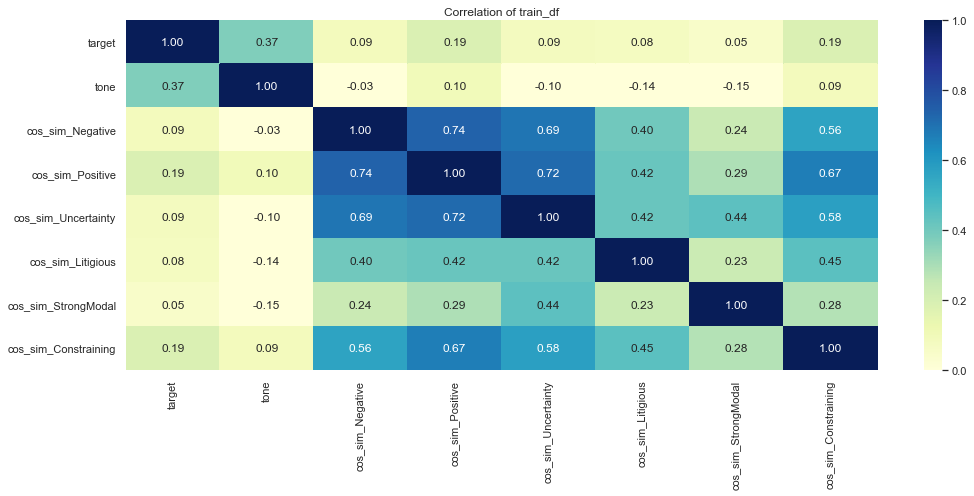

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

## Convert target class for classification 
We endcode the following for the results calculation i.e, Raise : 2, Hold : 1 and Lower: 0

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [ ]:
train_df['target'] = train_df['target'].map(convert_class)

In [ ]:
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

# Modeling and Training

We will create a common function to train the data for the 4 different models with F1 score and accuracy:


1.   Random Forrest Classifier using Cosine Similarity
2.   Random Forrest Classifier using Tf-idf Vector
3.   LSTM with Document Embeddings
4.   LSTM with Glove Embeddings





In [ ]:
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:


def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model



## A. Cosine Similarity
### Train and Test Data

In [ ]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [ ]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
[2020-11-21 21:52:11,429][INFO] ## Training - acc: 0.99500000, f1: 0.99276980
[2020-11-21 21:52:11,431][INFO] ## Test - acc: 0.56000000, f1: 0.34256757


Best Score:  0.6321444331764249
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 27}


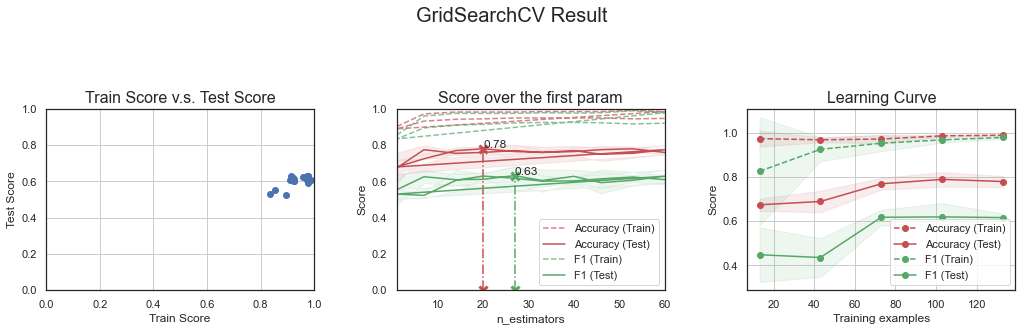

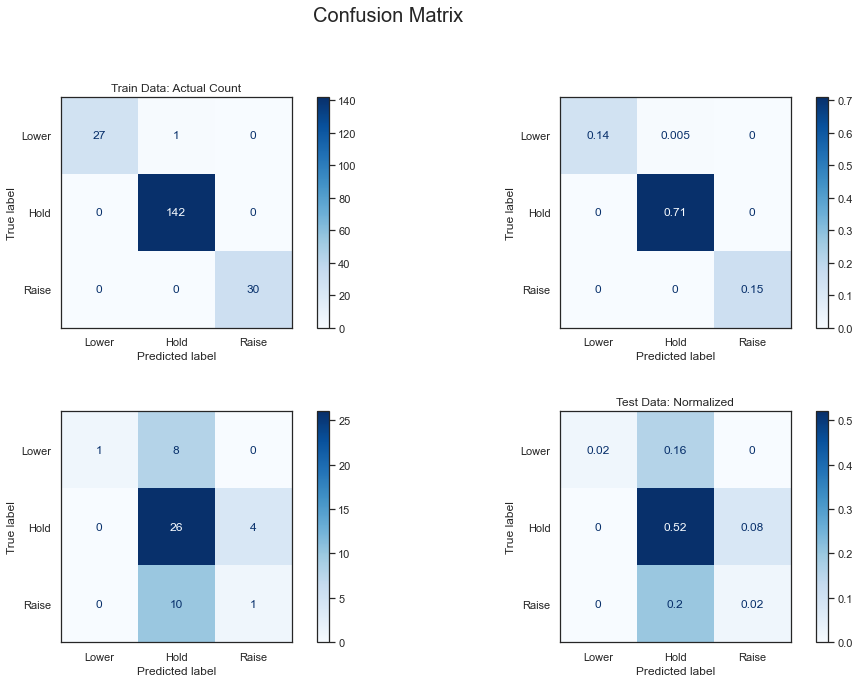

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

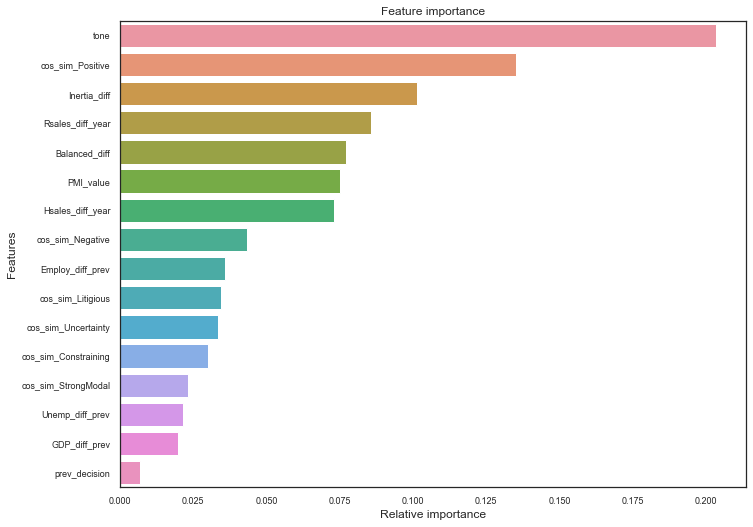

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")



## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [ ]:
train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1993-02-18       1              1       1.043165       55.8             261.0   
1993-05-18       1              1       0.167400       50.2             126.0   
1993-07-07       1              1       0.167400       49.6             226.5   
1993-08-17       1              1       0.582420       50.2             243.5   
1993-09-21       1              1       0.582420       50.7             228.5   
...            ...            ...            ...        ...               ...   
2020-06-10       1              1      -1.262655       43.1           -9031.0   
2020-07-29       1              1      -1.262655       52.6            3753.0   
2020-08-27       1              1      -8.986117       54.2            3271.0   
2020-09-16       1              1      -8.986117       56.0            1627.0   
2020-11-05       1              1       7.406283       59.3             655.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1993-02-18          1.738830         0.000000     -0.015867         14.901418   
1993-05-18          3.092456         0.066667     -0.000577         13.455236   
1993-07-07          4.263357         0.000000      0.050161         13.446869   
1993-08-17          4.611673         0.066667      0.002073         11.927296   
1993-09-21          4.894733         0.100000     -0.006598         10.302509   
...                      ...              ...           ...               ...   
2020-06-10        -12.969199        -3.266667     -0.419647         12.923545   
2020-07-29         -2.131270        -2.233333      0.216572         12.695924   
2020-08-27          1.582427         1.500000      0.135628         15.934227   
2020-09-16          1.539384         1.633333      0.066741         17.828644   
2020-11-05          2.658080         1.100000      0.137719         18.685443   

            Balanced_diff  ...  \
date                       ...   
1993-02-18       0.035737  ...   
1993-05-18       0.110562  ...   
1993-07-07      -0.016758  ...   
1993-08-17       0.028077  ...   
1993-09-21      -0.011247  ...   
...                   ...  ...   
2020-06-10      -0.190738  ...   
2020-07-29      -0.339976  ...   
2020-08-27      -0.346179  ...   
2020-09-16      -0.248988  ...   
2020-11-05      -0.642625  ...   

                                                                                                                                                                                                  tfidf_Uncertainty  \
date                                                                                                                                                                                                                  
1993-02-18  [0.0, 0.0, 0.03409951454790724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26914455561880707, 0.0, 0.0, 0.0, 0.05554171424300745, 0.0, 0.03731550281772454, 0.06762773657255576, 0.2586129156202969, 0.0, 0.0, 0.0, ...   
1993-05-18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08501677838249048, 0.0, 0.057118219639486344, 0.20703330356506827, 0.39585448943734264, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1993-07-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08597730606592487, 0.0, 0.0, 0.0, 0.0887130515034558, 0.0, 0.0, 0.10801724360494681, 0.3717585438982662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
1993-08-17  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15033383444537943, 0.0, 0.0, 0.0, 0.044319247246273674, 0.0, 0.029775728351883992, 0.10792646279340588, 0.14445126394220065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
1993-09-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15437650561909852, 0.0, 0.0, 0.0, 0.10619244791107657, 0.0, 0.0713450177628561, 0.0, 0.29667149037911633, 0.0, 0.0, 

In [ ]:
vocabulary=sentiment_dict['Negative']+sentiment_dict['Positive']

In [ ]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'tokenized_text']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
import scipy
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

from sklearn.preprocessing import FunctionTransformer
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

clf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', vocabulary=vocabulary))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   45.0s finished


Best Score:  0.3495258660877109
Best Param:  {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 7, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 1}


[2020-11-21 21:58:37,555][INFO] ## Training - acc: 0.78500000, f1: 0.64716302
[2020-11-21 21:58:37,558][INFO] ## Test - acc: 0.54000000, f1: 0.42083333


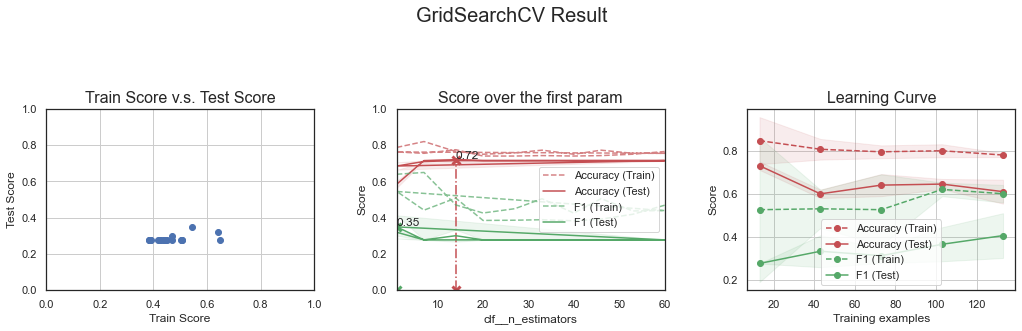

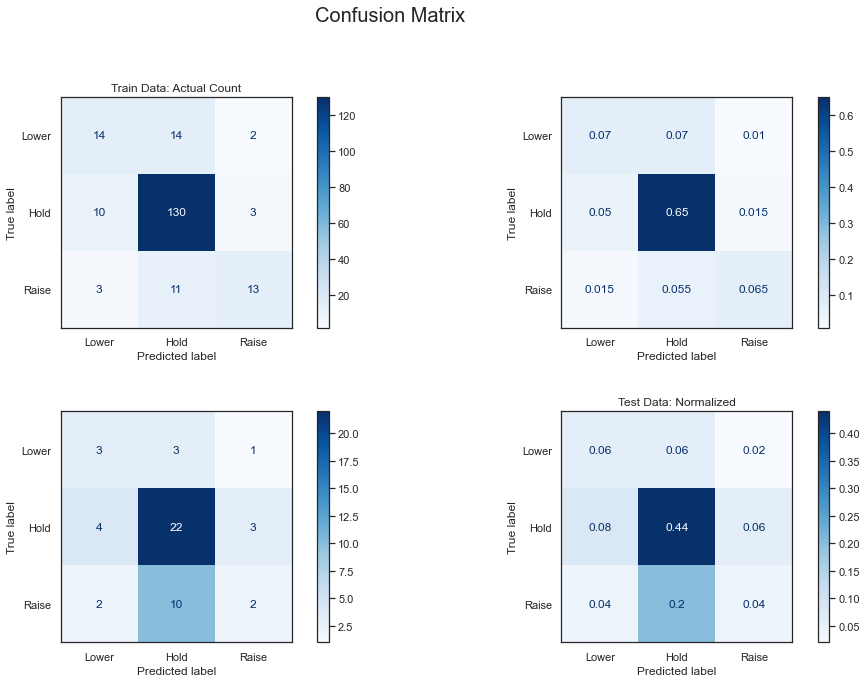

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

# Perform Grid Search
param_grid = {'clf__n_estimators': np.linspace(1, 60, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

rf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_




## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [ ]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 200
Shape of train text 200
Shape of valid meta  50
Shape of valid text  50
Meta data size:  9


### Model
#### Embed -> RNN -> Dense -> Softmax

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching


In [ ]:
def dataloader(messages, meta, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        meta = [meta[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
        
        yield batch, meta_tensor, label_tensor

In [ ]:
# Test
text_batch, meta_batch, labels = next(iter(dataloader(X_train_text, X_train_meta, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, meta_size, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, meta_batch, hidden)
print(logps)

tensor([[-1.2180e+01, -5.1260e-06, -3.4423e+01],
        [-7.7158e+00, -4.7541e-04, -1.0428e+01],
        [-5.7857e+00, -3.0765e-03, -1.4483e+01],
        [-2.1308e+00, -1.2951e-01, -5.9047e+00],
        [-3.4344e+00, -4.2271e-02, -4.6946e+00],
        [-2.3736e+01, -4.4269e+01,  0.0000e+00],
        [-4.3816e+01,  0.0000e+00, -9.6399e+01],
        [-4.0181e+00, -1.8231e-02, -9.4500e+00],
        [-2.4324e+01, -3.0348e+01,  0.0000e+00],
        [-4.8196e+00, -8.1190e-03, -1.1050e+01],
        [-7.5081e+00, -8.9427e-04, -7.9710e+00],
        [-5.8737e-01, -1.0662e+00, -2.3038e+00],
        [-2.0047e+00, -4.1724e+00, -1.6266e-01],
        [-5.1712e+00, -7.8740e-03, -6.1352e+00],
        [-5.6436e+00, -3.5839e-03, -1.0192e+01],
        [-4.1766e+00, -1.5730e-02, -8.2697e+00]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [ ]:
# Set Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(20509, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
def train_model(model, epochs=3, batch_size=8, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, meta_batch, labels in dataloader(
                X_train_text, X_train_meta, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, meta_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, meta_batch, labels in dataloader(
                        X_valid_text, X_valid_meta, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, meta_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Lower', 'Hold', 'Raise']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 15.837022... Val Loss: 15.806655 Accuracy: 0.375000 F1 Score: 0.246561
Epoch: 1/3... Step: 20... Loss: 5.459225... Val Loss: 15.569336 Accuracy: 0.375000 F1 Score: 0.246561
25 steps in epoch 1

Epoch: 1, Average Accuracy: 0.37500000, Average f1: 0.24656085



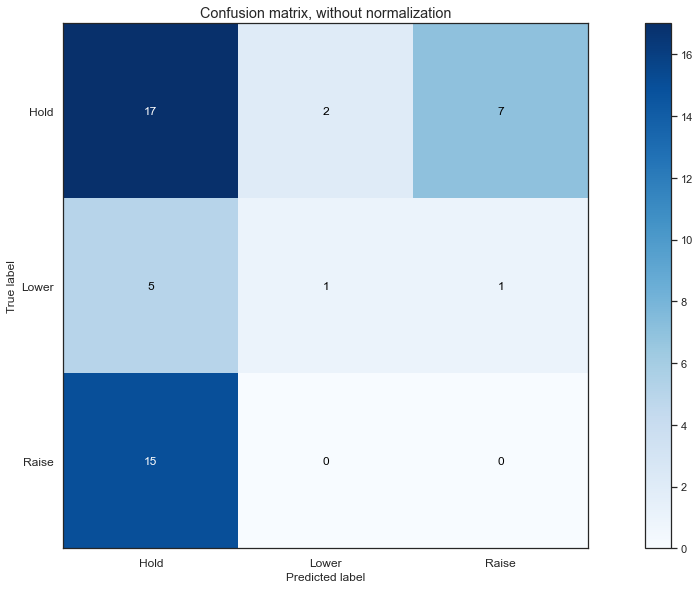

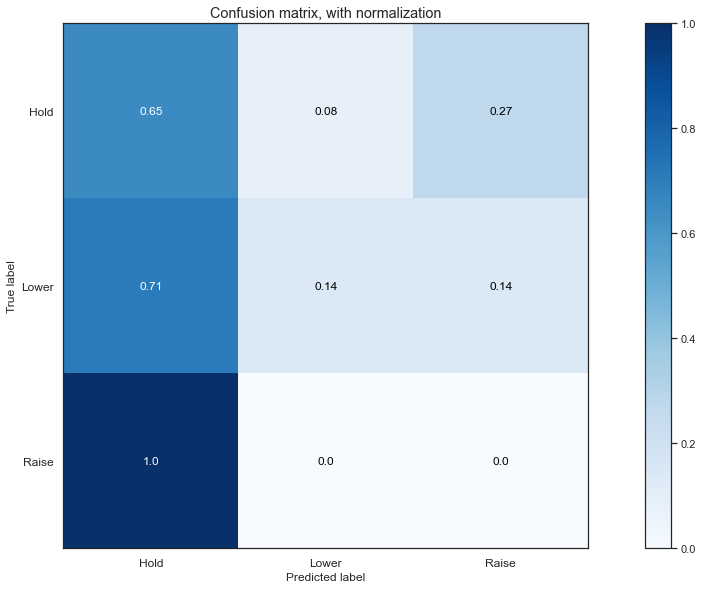

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 15.369466... Val Loss: 15.195109 Accuracy: 0.375000 F1 Score: 0.246561
Epoch: 2/3... Step: 20... Loss: 5.188633... Val Loss: 14.959802 Accuracy: 0.375000 F1 Score: 0.246561
25 steps in epoch 2

Epoch: 2, Average Accuracy: 0.37500000, Average f1: 0.24656085



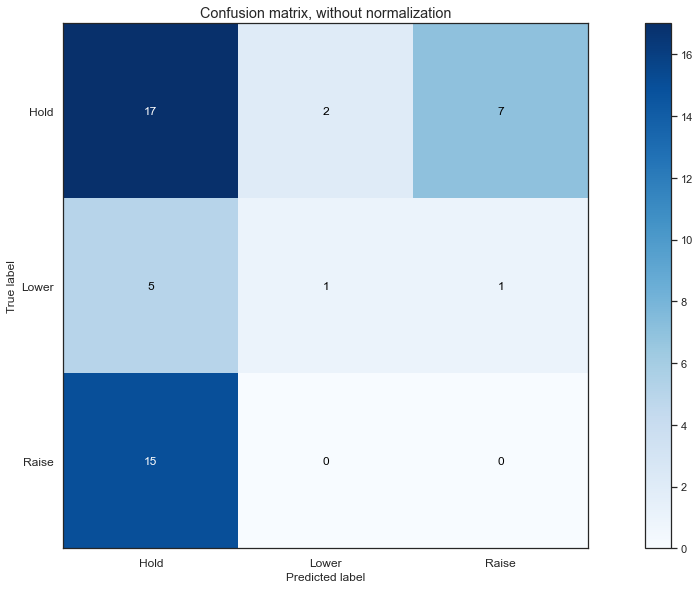

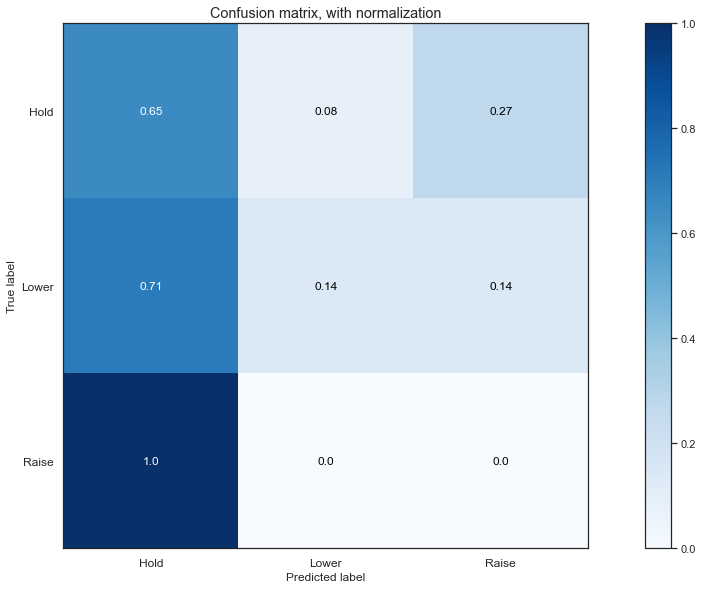

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 14.899013... Val Loss: 14.585990 Accuracy: 0.375000 F1 Score: 0.246561
Epoch: 3/3... Step: 20... Loss: 4.924715... Val Loss: 14.351416 Accuracy: 0.375000 F1 Score: 0.246561
25 steps in epoch 3

Epoch: 3, Average Accuracy: 0.37500000, Average f1: 0.24656085



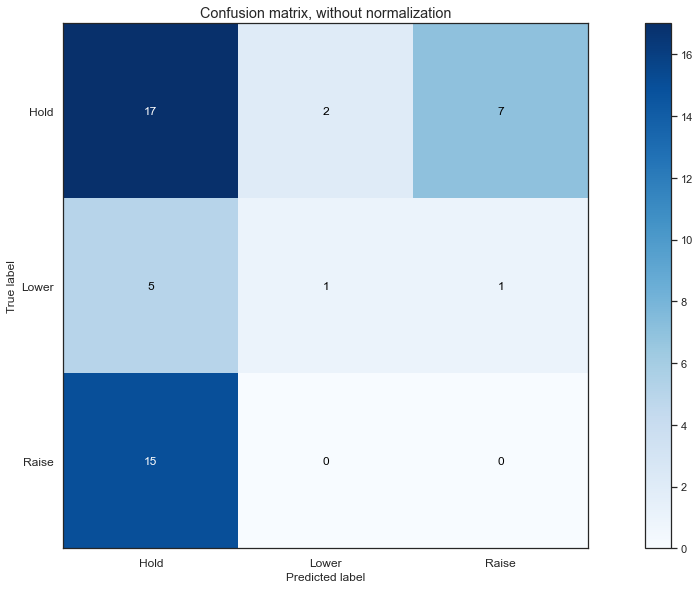

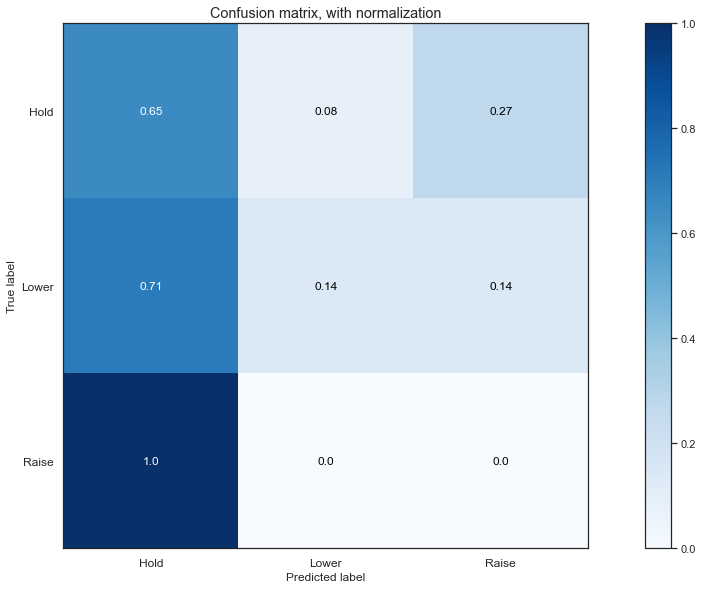

In [ ]:
train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

### Download GloVe files 
Please download the Glove Model Embeddings from the following website http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
print(glove_dir)
embedding_dict = {}

with open(glove_dir + "/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()
glove_path = glove_dir+"/glove.6B.300d.pickle"
pickle.dump(embedding_dict, open(glove_path, 'wb'))

../data/GloVe


In [ ]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [ ]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

11779 words found out of 20508 words in vocab.
(20508, 300)


In [ ]:
type(weight_matrix)

numpy.ndarray

In [ ]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

# Configuring the model and training!!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(20508, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 47.466396... Val Loss: 68.814814 Accuracy: 0.145833 F1 Score: 0.136752
Epoch: 1/3... Step: 20... Loss: 68.750648... Val Loss: 68.300648 Accuracy: 0.145833 F1 Score: 0.136752
25 steps in epoch 1

Epoch: 1, Average Accuracy: 0.14583333, Average f1: 0.13675214



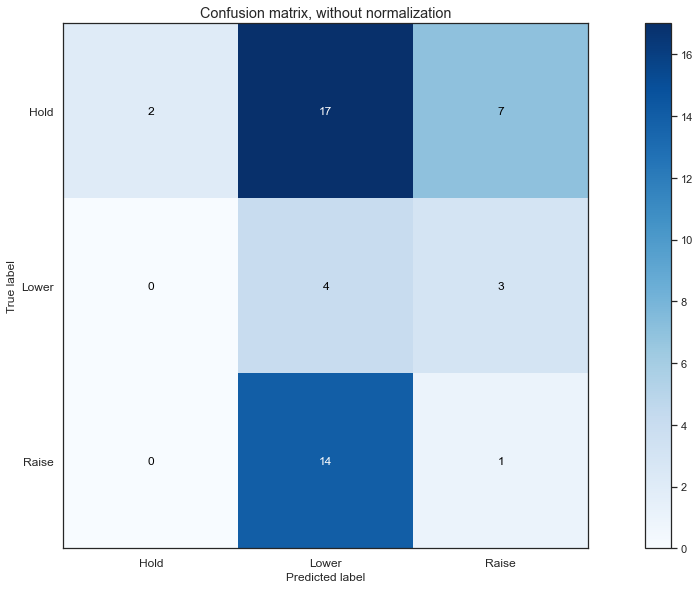

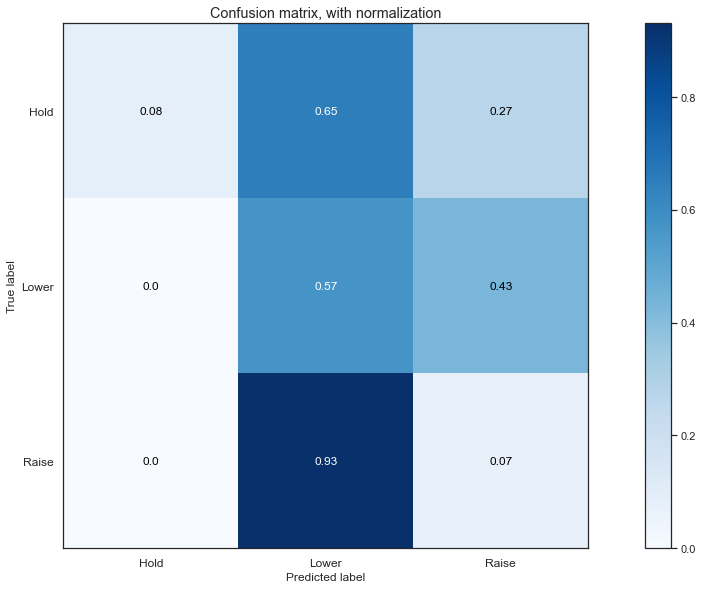

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 46.645283... Val Loss: 67.533252 Accuracy: 0.145833 F1 Score: 0.136752
Epoch: 2/3... Step: 20... Loss: 67.272270... Val Loss: 67.014968 Accuracy: 0.145833 F1 Score: 0.136752
25 steps in epoch 2

Epoch: 2, Average Accuracy: 0.14583333, Average f1: 0.13675214



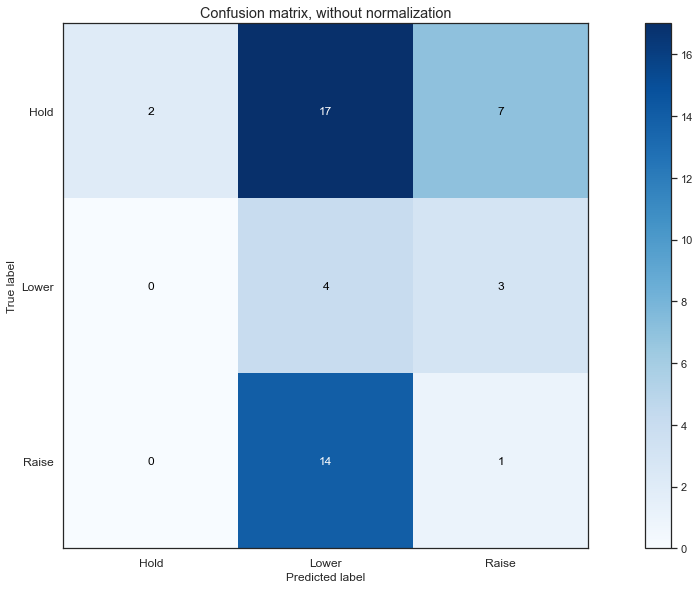

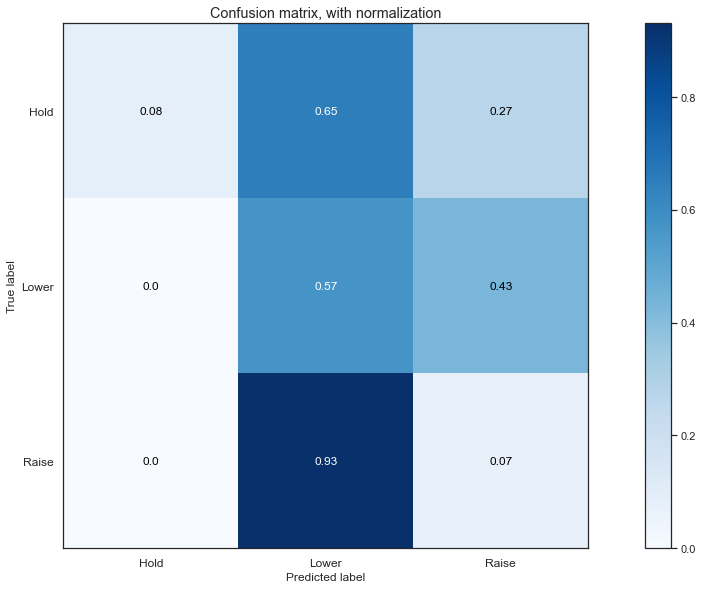

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 45.794411... Val Loss: 66.214462 Accuracy: 0.145833 F1 Score: 0.136752
Epoch: 3/3... Step: 20... Loss: 65.646126... Val Loss: 65.625579 Accuracy: 0.145833 F1 Score: 0.136752
25 steps in epoch 3

Epoch: 3, Average Accuracy: 0.14583333, Average f1: 0.13675214



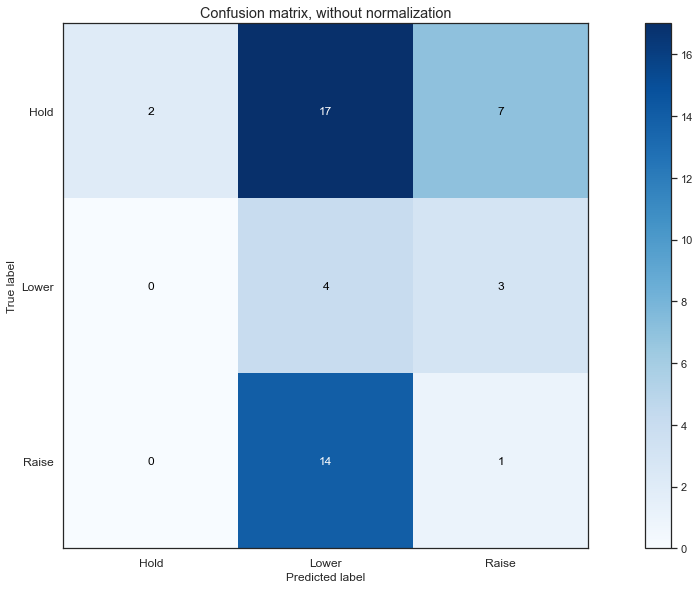

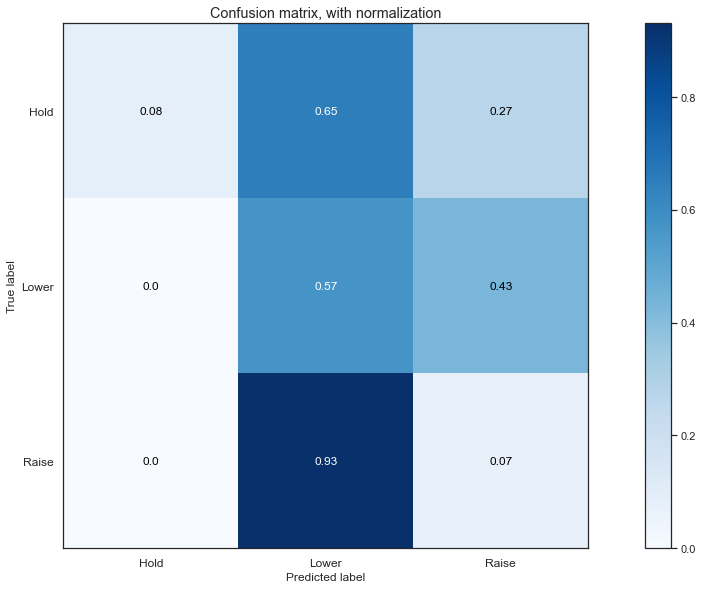

In [ ]:
train_model(model)

In [ ]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [ ]:
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'presconf_script', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'])

In [ ]:
split_train_df.shape

(250, 12)

In [ ]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            #row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)

    return split_df

In [ ]:
split_train_df = get_split_df(split_train_df)
split_train_df.shape

(21154, 12)

In [ ]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

# Add to the dataframe
split_train_df['token_ids'] = token_ids



In [ ]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))
        

In [ ]:
split_train_df.head()

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
0       1              1       1.043165       55.8             261.0   
1       1              1       1.043165       55.8             261.0   
2       1              1       1.043165       55.8             261.0   
3       1              1       1.043165       55.8             261.0   
4       1              1       1.043165       55.8             261.0   

   Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
0           1.73883              0.0     -0.015867         14.901418   
1           1.73883              0.0     -0.015867         14.901418   
2           1.73883              0.0     -0.015867         14.901418   
3           1.73883              0.0     -0.015867         14.901418   
4           1.73883              0.0     -0.015867         14.901418   

   Balanced_diff  \
0       0.035737   
1       0.035737   
2       0.035737   
3       0.035737   
4       0.035737   

                                                                                                                                                                                                      text  \
0  The Secretary reported that advices of the election of the Reserve Bank members and alternate members of the Federal Open Market Committee for the period commencing January and ending December had...   
1  Manager of the System Open Market Account Deputy Manager for Foreign Operations System Open Market Account and Deputy Manager for Domestic Operations System Open Market Account respectively on the...   
2  the System Open Market Account that were contained in the following Procedures for allocation of securities in the System Open Market Account and Program for Security of FOMC Information Apart fro...   
3  allow them to mature without replacement provided that the aggregate amount of U S Government and Federal agency securities held in such Account including forward commitments at the close of busin...   
4  to nine months at the time of acceptance that arise out of the current shipment of goods between countries or within the United States or arise out of the storage within the United States of goods...   

       tone  \
0 -0.146711   
1 -0.146711   
2 -0.146711   
3 -0.146711   
4 -0.146711   

                                                                                                                                                                                                 token_ids  
0           [1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1, 24, 8, 9, 8, 25, 26, 27, 28, 13, 24, 25, 29, 10, 11, 12, 13, 30, 5, 31, 32, 33, 13, 18, 34, 35, ...]  
1  [55, 56, 11, 12, 57, 58, 55, 59, 60, 56, 11, 12, 57, 58, 55, 61, 60, 56, 11, 12, 57, 62, 34, 63, 64, 65, 10, 6, 7, 66, 67, 68, 16, 69, 70, 71, 72, 73, 13, 74, 75, 4, 76, 77, 78, 13, 79, 13, 80, 81...  
2  [56, 11, 12, 57, 103, 25, 77, 104, 105, 56, 11, 12, 57, 106, 105, 107, 108, 109, 90, 100, 110, 73, 74, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 105, 121, 105, 10, 122, 7, 105, 123, 124, 1...  
3  [144, 142, 145, 146, 147, 148, 149, 118, 119, 120, 10, 129, 105, 150, 57, 121, 151, 152, 153, 154, 155, 33, 13, 156, 157, 158, 61, 159, 160, 161, 162, 163, 164, 14, 15, 11, 154, 155, 25, 33, 17, 1...  
4  [175, 176, 177, 169, 178, 179, 180, 181, 182, 183, 130, 131, 178, 184, 183, 130, 131, 181, 185, 186, 187, 188, 189, 190, 183, 191, 177, 192, 193, 194, 195, 196, 197, 198, 199, 110, 200, 181, 147, ...

<AxesSubplot:xlabel='text', ylabel='Density'>

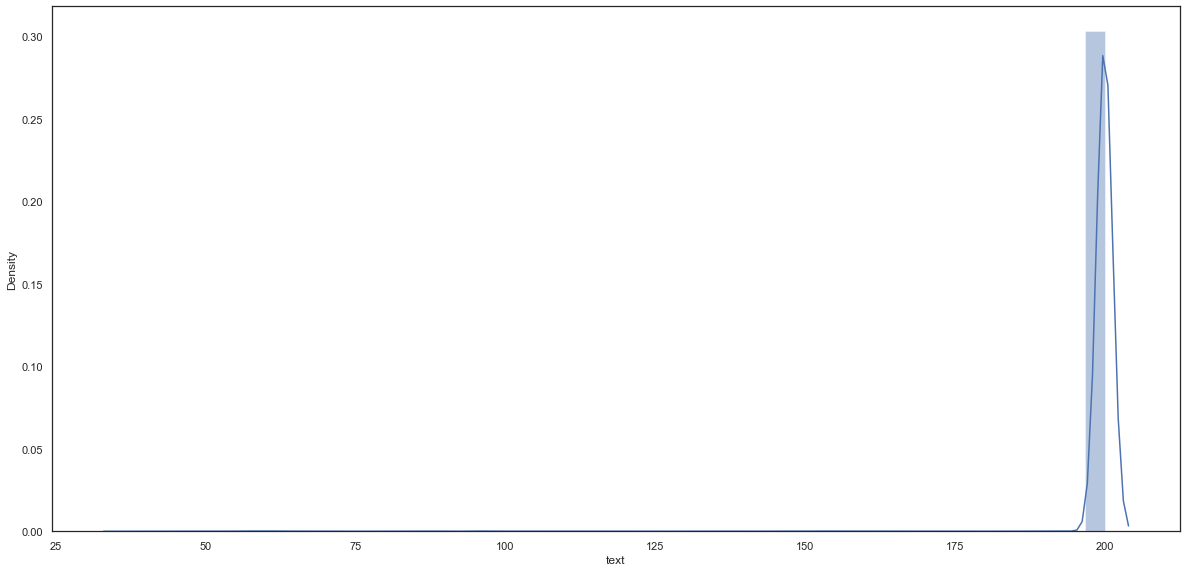

In [ ]:
sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))

In [ ]:
# X and Y data used
y_data = split_train_df['target']
X_data = split_train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 16923
Shape of train text 16923
Shape of valid meta  4231
Shape of valid text  4231
Meta data size:  9


In [ ]:
len(weight_matrix)

20965

In [ ]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(20965, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 17.151825... Val Loss: 34.719184 Accuracy: 0.236032 F1 Score: 0.238404
Epoch: 1/3... Step: 20... Loss: 5.134022... Val Loss: 34.447259 Accuracy: 0.234375 F1 Score: 0.238618
Epoch: 1/3... Step: 30... Loss: 27.540745... Val Loss: 34.178211 Accuracy: 0.253788 F1 Score: 0.256638
Epoch: 1/3... Step: 40... Loss: 10.368647... Val Loss: 33.912334 Accuracy: 0.254025 F1 Score: 0.257597
Epoch: 1/3... Step: 50... Loss: 9.871666... Val Loss: 33.636828 Accuracy: 0.265862 F1 Score: 0.269866
Epoch: 1/3... Step: 60... Loss: 5.313892... Val Loss: 33.295961 Accuracy: 0.267992 F1 Score: 0.273374
Epoch: 1/3... Step: 70... Loss: 9.591395... Val Loss: 32.819817 Accuracy: 0.323627 F1 Score: 0.310041
Epoch: 1/3... Step: 80... Loss: 4.275852... Val Loss: 32.365184 Accuracy: 0.369081 F1 Score: 0.334268
Epoch: 1/3... Step: 90... Loss: 29.216225... Val Loss: 31.996406 Accuracy: 0.393229 F1 Score: 0.343559
Epoch: 1/3... Step: 100... Loss: 10.944061... Val Loss: 31.69

Epoch: 1/3... Step: 800... Loss: 1.096443... Val Loss: 17.627146 Accuracy: 0.593040 F1 Score: 0.391361
Epoch: 1/3... Step: 810... Loss: 10.871861... Val Loss: 17.531935 Accuracy: 0.593040 F1 Score: 0.391361
Epoch: 1/3... Step: 820... Loss: 1.609937... Val Loss: 17.432463 Accuracy: 0.602509 F1 Score: 0.396272
Epoch: 1/3... Step: 830... Loss: 6.045004... Val Loss: 17.314981 Accuracy: 0.597301 F1 Score: 0.352503
Epoch: 1/3... Step: 840... Loss: 3.302952... Val Loss: 17.180010 Accuracy: 0.597301 F1 Score: 0.352503
Epoch: 1/3... Step: 850... Loss: 1.146442... Val Loss: 17.049570 Accuracy: 0.589252 F1 Score: 0.373659
Epoch: 1/3... Step: 860... Loss: 2.017351... Val Loss: 16.948241 Accuracy: 0.587595 F1 Score: 0.383137
Epoch: 1/3... Step: 870... Loss: 10.992788... Val Loss: 16.852544 Accuracy: 0.589725 F1 Score: 0.384223
Epoch: 1/3... Step: 880... Loss: 4.119809... Val Loss: 16.734096 Accuracy: 0.608665 F1 Score: 0.356699
Epoch: 1/3... Step: 890... Loss: 222.163544... Val Loss: 16.609511 Accu

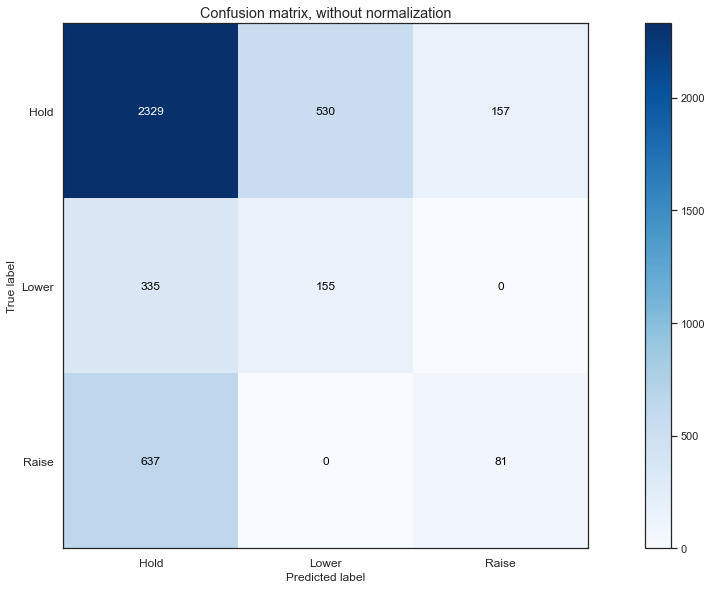

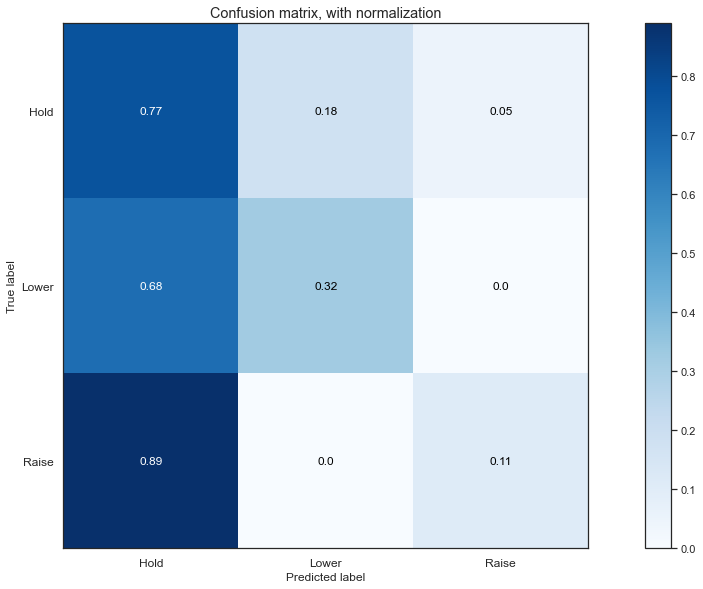

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 4.681956... Val Loss: 14.433213 Accuracy: 0.604403 F1 Score: 0.376715
Epoch: 2/3... Step: 20... Loss: 1.573659... Val Loss: 14.295911 Accuracy: 0.610085 F1 Score: 0.392053
Epoch: 2/3... Step: 30... Loss: 9.349771... Val Loss: 14.157557 Accuracy: 0.605587 F1 Score: 0.389703
Epoch: 2/3... Step: 40... Loss: 3.147889... Val Loss: 14.027715 Accuracy: 0.601562 F1 Score: 0.391805
Epoch: 2/3... Step: 50... Loss: 2.728289... Val Loss: 13.914541 Accuracy: 0.595170 F1 Score: 0.407840
Epoch: 2/3... Step: 60... Loss: 1.590512... Val Loss: 13.791155 Accuracy: 0.594697 F1 Score: 0.391185
Epoch: 2/3... Step: 70... Loss: 3.290118... Val Loss: 13.662353 Accuracy: 0.604167 F1 Score: 0.388968
Epoch: 2/3... Step: 80... Loss: 1.870023... Val Loss: 13.525062 Accuracy: 0.605114 F1 Score: 0.389546
Epoch: 2/3... Step: 90... Loss: 10.864793... Val Loss: 13.398050 Accuracy: 0.611032 F1 Score: 0.392629
Epoch: 2/3... Step: 100... Loss: 4.260028... Val Loss: 13.262171

Epoch: 2/3... Step: 810... Loss: 3.726017... Val Loss: 5.207806 Accuracy: 0.655540 F1 Score: 0.421236
Epoch: 2/3... Step: 820... Loss: 1.794273... Val Loss: 5.126165 Accuracy: 0.661695 F1 Score: 0.425705
Epoch: 2/3... Step: 830... Loss: 1.535425... Val Loss: 5.023913 Accuracy: 0.670218 F1 Score: 0.431269
Epoch: 2/3... Step: 840... Loss: 1.579051... Val Loss: 4.927502 Accuracy: 0.667140 F1 Score: 0.417227
Epoch: 2/3... Step: 850... Loss: 1.607740... Val Loss: 4.844516 Accuracy: 0.666667 F1 Score: 0.429421
Epoch: 2/3... Step: 860... Loss: 1.419845... Val Loss: 4.770101 Accuracy: 0.656250 F1 Score: 0.426708
Epoch: 2/3... Step: 870... Loss: 2.331210... Val Loss: 4.696278 Accuracy: 0.639915 F1 Score: 0.418285
Epoch: 2/3... Step: 880... Loss: 1.360606... Val Loss: 4.602244 Accuracy: 0.659091 F1 Score: 0.423797
Epoch: 2/3... Step: 890... Loss: 60.651981... Val Loss: 4.513618 Accuracy: 0.660511 F1 Score: 0.399683
Epoch: 2/3... Step: 900... Loss: 29.064991... Val Loss: 4.407486 Accuracy: 0.6605

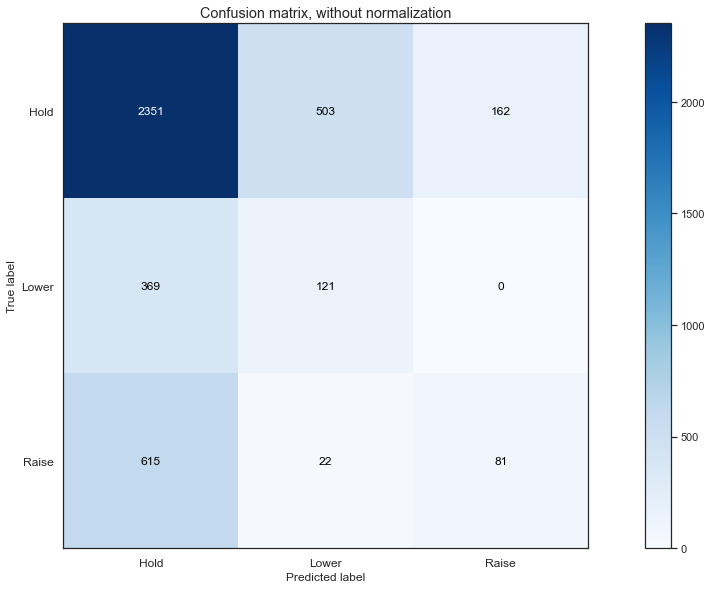

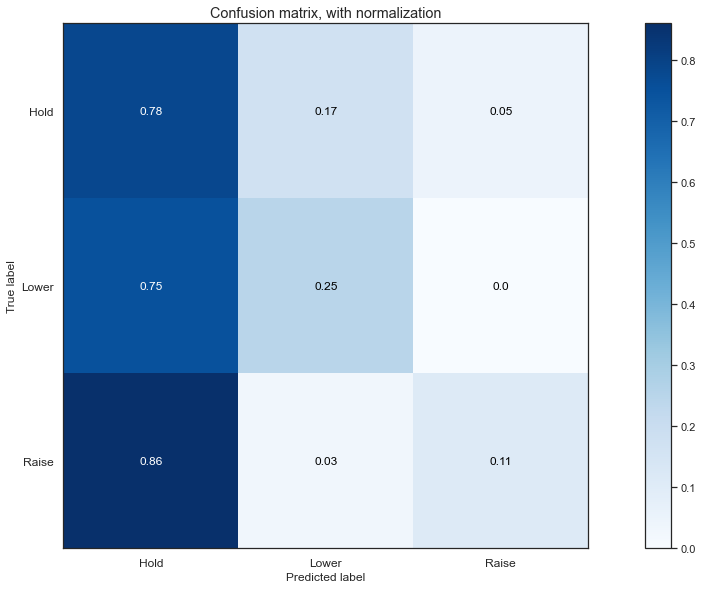

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 0.658235... Val Loss: 3.144278 Accuracy: 0.608665 F1 Score: 0.383979
Epoch: 3/3... Step: 20... Loss: 1.516763... Val Loss: 3.088135 Accuracy: 0.622633 F1 Score: 0.383945
Epoch: 3/3... Step: 30... Loss: 0.849990... Val Loss: 3.015800 Accuracy: 0.635417 F1 Score: 0.391665
Epoch: 3/3... Step: 40... Loss: 0.966694... Val Loss: 2.947310 Accuracy: 0.633286 F1 Score: 0.385137
Epoch: 3/3... Step: 50... Loss: 1.573016... Val Loss: 2.908671 Accuracy: 0.614583 F1 Score: 0.375017
Epoch: 3/3... Step: 60... Loss: 0.718507... Val Loss: 2.885737 Accuracy: 0.617898 F1 Score: 0.376714
Epoch: 3/3... Step: 70... Loss: 2.273539... Val Loss: 2.863838 Accuracy: 0.625473 F1 Score: 0.380668
Epoch: 3/3... Step: 80... Loss: 1.980467... Val Loss: 2.828619 Accuracy: 0.614583 F1 Score: 0.375017
Epoch: 3/3... Step: 90... Loss: 1.068260... Val Loss: 2.775570 Accuracy: 0.625473 F1 Score: 0.380668
Epoch: 3/3... Step: 100... Loss: 1.364676... Val Loss: 2.719479 Accuracy: 

Epoch: 3/3... Step: 820... Loss: 1.469952... Val Loss: 2.068306 Accuracy: 0.633286 F1 Score: 0.383984
Epoch: 3/3... Step: 830... Loss: 0.595580... Val Loss: 2.069632 Accuracy: 0.675663 F1 Score: 0.385215
Epoch: 3/3... Step: 840... Loss: 1.372515... Val Loss: 2.098077 Accuracy: 0.689394 F1 Score: 0.376471
Epoch: 3/3... Step: 850... Loss: 1.524146... Val Loss: 2.105755 Accuracy: 0.696259 F1 Score: 0.394315
Epoch: 3/3... Step: 860... Loss: 1.106752... Val Loss: 2.122100 Accuracy: 0.684186 F1 Score: 0.387164
Epoch: 3/3... Step: 870... Loss: 1.095196... Val Loss: 2.129080 Accuracy: 0.678741 F1 Score: 0.370506
Epoch: 3/3... Step: 880... Loss: 0.895451... Val Loss: 2.120731 Accuracy: 0.687500 F1 Score: 0.371605
Epoch: 3/3... Step: 890... Loss: 22.937620... Val Loss: 2.076498 Accuracy: 0.684422 F1 Score: 0.369701
Epoch: 3/3... Step: 900... Loss: 11.002122... Val Loss: 2.008128 Accuracy: 0.661222 F1 Score: 0.373556
Epoch: 3/3... Step: 910... Loss: 0.669210... Val Loss: 1.977405 Accuracy: 0.6458

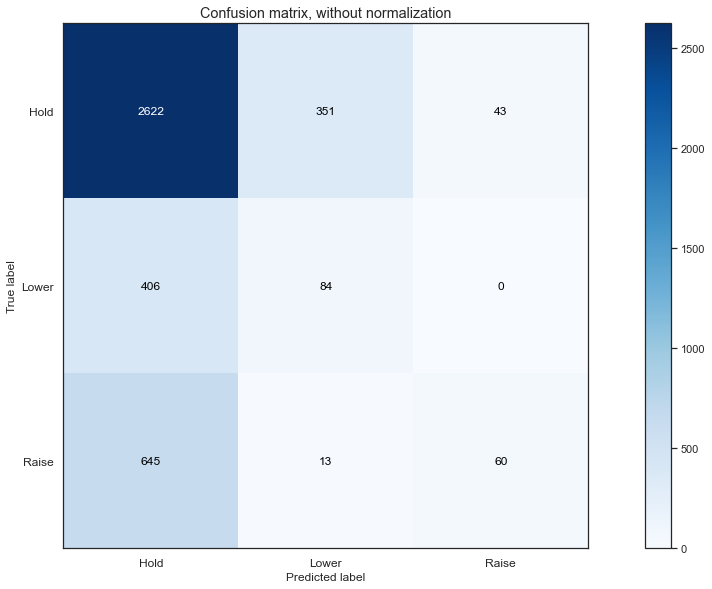

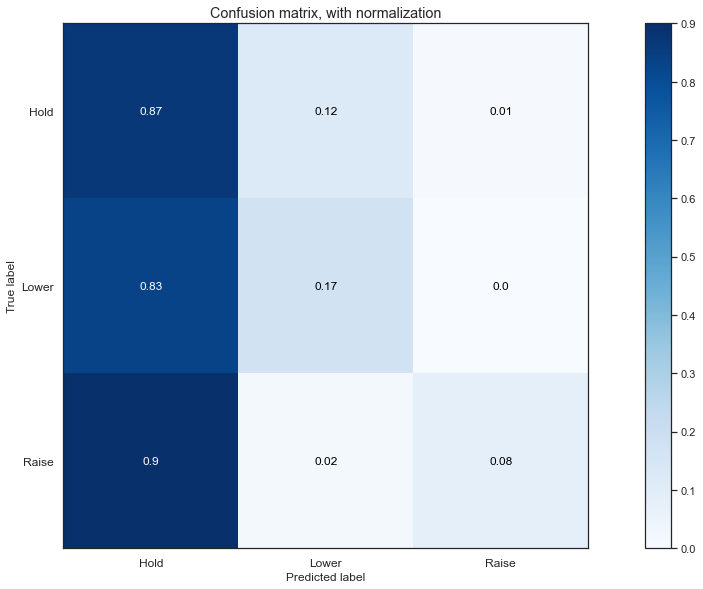

In [ ]:
train_model(model, epochs=3, batch_size=16, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10)

In [ ]:
.j